In [1]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
)
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, cross_val_predict,
    GridSearchCV, cross_val_score
)
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib as mpl
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('Data_1.csv')

# Display the first few rows of the dataset
df.head()

,m49_code,country,region,cpc_code,commodity,year,loss_percentage,loss_percentage_original,loss_quantity,activity,food_supply_stage,treatment,cause_of_loss,sample_size,method_data_collection,reference,url,notes
0,108,Burundi,NaN,111.0,Wheat,2021,4.43333,4.43333,NaN,"Drying, Harvesting",Harvest,NaN,NaN,NaN,Modelled Estimates,NaN,https://www.aphlis.net/en/data/tables/value-ch...,NaN
1,108,Burundi,NaN,111.0,Wheat,2021,4.86667,4.86667,NaN,Storage,Farm,NaN,NaN,NaN,Modelled Estimates,NaN,https://www.aphlis.net/en/data/tables/value-ch...,NaN
2,108,Burundi,NaN,111.0,Wheat,2021,3.50000,3.5,NaN,"Shelling, Threshing",NaN,NaN,NaN,NaN,Modelled Estimates,NaN,https://www.aphlis.net/en/data/tables/value-ch...,NaN
3,108,Burundi,NaN,111.0,Wheat,2021,2.50000,2.5,NaN,Transportation,Farm,NaN,NaN,NaN,Modelled Estimates,NaN,https://www.aphlis.net/en/data/tables/value-ch...,NaN
4,108,Burundi,NaN,112.0,Maize (corn),2021,6.42000,6.42,NaN,"Drying, Harvesting",Harvest,NaN,NaN,NaN,Modelled Estimates,NaN,https://www.aphlis.net/en/data/tables/value-ch...,NaN


In [3]:
# produces data-summary descriptive statistics.
df.describe

<bound method NDFrame.describe of       m49_code  country region  cpc_code     commodity  year  loss_percentage  \
0          108  Burundi    NaN     111.0         Wheat  2021          4.43333   
1          108  Burundi    NaN     111.0         Wheat  2021          4.86667   
2          108  Burundi    NaN     111.0         Wheat  2021          3.50000   
3          108  Burundi    NaN     111.0         Wheat  2021          2.50000   
4          108  Burundi    NaN     112.0  Maize (corn)  2021          6.42000   
...        ...      ...    ...       ...           ...   ...              ...   
1817       894   Zambia    NaN     118.0        Millet  2020          2.61612   
1818       894   Zambia    NaN     118.0        Millet  2020          1.00000   
1819       894   Zambia    NaN     118.0        Millet  2020          3.43613   
1820       894   Zambia    NaN     118.0        Millet  2020          2.50000   
1821       894   Zambia    NaN     118.0        Millet  2020          2.000

In [4]:
# Calculate the limit as half the number of rows in the DataFrame
limit = len(df) * 0.5

# Drop columns where the number of null values is more then the limit
df = df.dropna(thresh=limit, axis=1)

In [5]:
# Remove any rows that have any missing values.
df = df.dropna()

In [6]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

In [7]:
# Determine how many values are missing in each column.
df.isna().sum()

m49_code                    0
country                     0
cpc_code                    0
commodity                   0
year                        0
loss_percentage             0
loss_percentage_original    0
activity                    0
food_supply_stage           0
method_data_collection      0
url                         0
dtype: int64

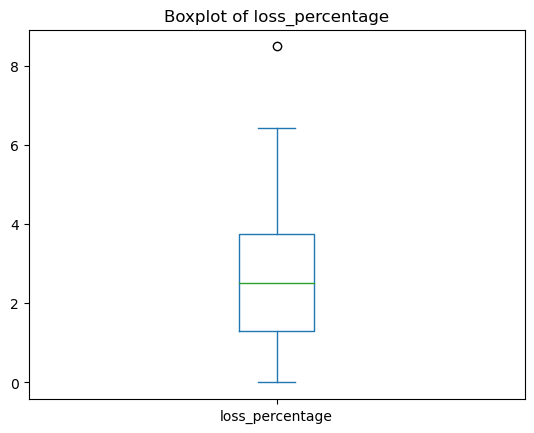

Original DataFrame size: (1422, 11)
DataFrame size after removing outliers: (1421, 11)


In [8]:
# Plot the loss_percentage column as a boxplot
df['loss_percentage'].plot(kind='box')

# The plot's title.
plt.title('Boxplot of loss_percentage')

# Display plot
plt.show()

# Calculate the loss_percentage Q1, Q3, and IQR to find outliers
Q1 = df['loss_percentage'].quantile(0.25)
Q3 = df['loss_percentage'].quantile(0.75)
IQR = Q3 - Q1

# Determine the outliers
outliers = df[(df['loss_percentage'] < (Q1 - 1.5 * IQR)) | (df['loss_percentage'] > (Q3 + 1.5 * IQR))]

# Remove the outliers
df_no_outliers = df[~((df['loss_percentage'] < (Q1 - 1.5 * IQR)) | (df['loss_percentage'] > (Q3 + 1.5 * IQR)))]

# Print how many outliers were removed
print(f"Original DataFrame size: {df.shape}")
print(f"DataFrame size after removing outliers: {df_no_outliers.shape}")

# change the name back
df = df_no_outliers

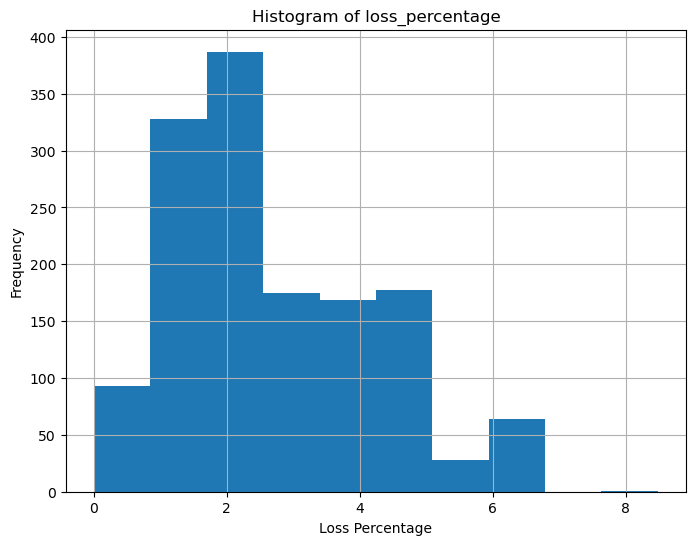

In [9]:
# plot a histogram for loss percentage
df['loss_percentage'].hist(figsize=(8, 6))
plt.title('Histogram of loss_percentage')

# labels for the axes
plt.xlabel('Loss Percentage')
plt.ylabel('Frequency')
plt.show()

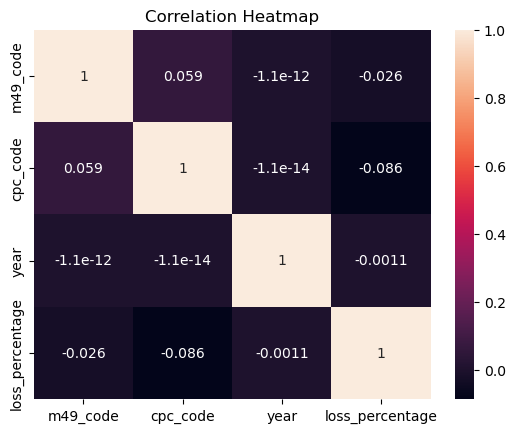

In [10]:
# correlation matrix based on the numerical columns
correlation_matrix = df.corr(numeric_only=True)

# Plot the correlation heatmap
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

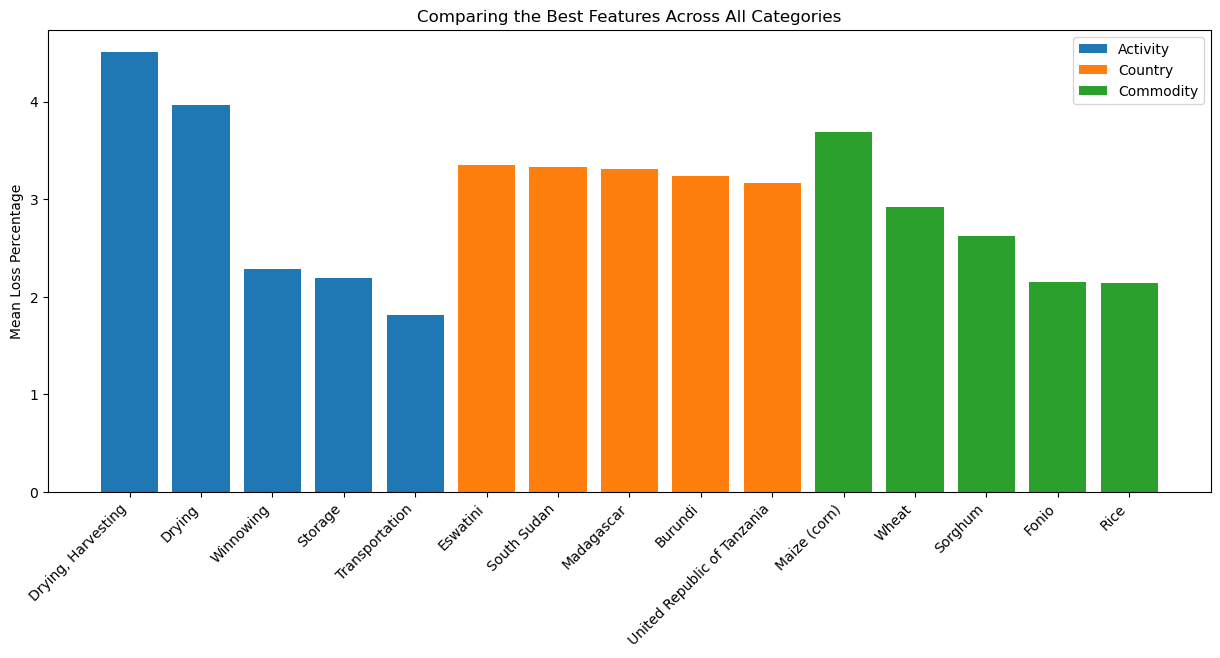

In [11]:
# get the average loss percentage for each category
activity_category = df.groupby('activity')['loss_percentage'].mean()
country_category = df.groupby('country')['loss_percentage'].mean()
commodity_category = df.groupby('commodity')['loss_percentage'].mean()

# number of feature used for plot
top_features = 5
plt.figure(figsize=(15, 6))

# Activity
activity_feature = activity_category.nlargest(top_features)
plt.bar(activity_feature.index, activity_feature.values, label='Activity')

# Country
country_feature = country_category.nlargest(top_features)
plt.bar(country_feature.index, country_feature.values, label='Country')

# Commodity
commodity_feature = commodity_category.nlargest(top_features)
plt.bar(commodity_feature.index, commodity_feature.values, label='Commodity')

# plot the barchart
plt.title('Comparing the Best Features Across All Categories')
plt.ylabel('Mean Loss Percentage')
plt.legend()
plt.xticks(rotation=45, ha='right') 
plt.show()

In [12]:
# Clasify loss percentage with bins
bins = [0, 3, 6, 9]

# different classification waste for loss percentage
labels = ['Low Waste', 'Medium Waste', 'High Waste']

# Add new column to dataset
df['waste_category'] = pd.cut(df['loss_percentage'], bins=bins, labels=labels, include_lowest=True)

# Print the number of each category of waste
print(df['waste_category'].value_counts())


waste_category
Low Waste       965
Medium Waste    394
High Waste       63
Name: count, dtype: int64


In [13]:
# List of categorical features
categorical_features = ['country', 'commodity', 'activity', 'food_supply_stage']

# List of numerical features
numerical_features = ['year']

# Apply normalisation to features
Standardisation = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])

In [15]:
# Define features X by dropping specified columns
X = df.drop(['waste_category', 'url', 'loss_percentage_original', 'm49_code', 'cpc_code', 'loss_percentage', 'method_data_collection'], axis=1)

# Define target y as waste_category 
y = df['waste_category']

In [16]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Shows the current features left
X.head()

,country,commodity,year,activity,food_supply_stage
0,Burundi,Wheat,2021,"Drying, Harvesting",Harvest
1,Burundi,Wheat,2021,Storage,Farm
3,Burundi,Wheat,2021,Transportation,Farm
4,Burundi,Maize (corn),2021,"Drying, Harvesting",Harvest
6,Burundi,Maize (corn),2021,Storage,Farm


logistic regression Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
logistic regression Best cross-validation score: 0.962
logistic regression Cross-validated Accuracy: 0.953

logistic regression Classification Report:
              precision    recall  f1-score   support

  High Waste       0.64      1.00      0.78         9
   Low Waste       0.99      0.96      0.98       254
Medium Waste       0.90      0.91      0.91        93

    accuracy                           0.95       356
   macro avg       0.85      0.96      0.89       356
weighted avg       0.96      0.95      0.95       356



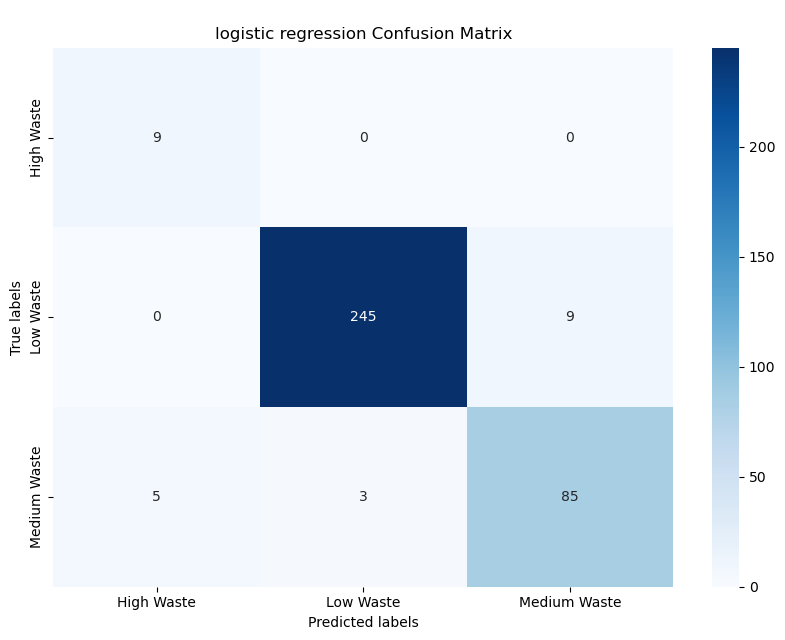

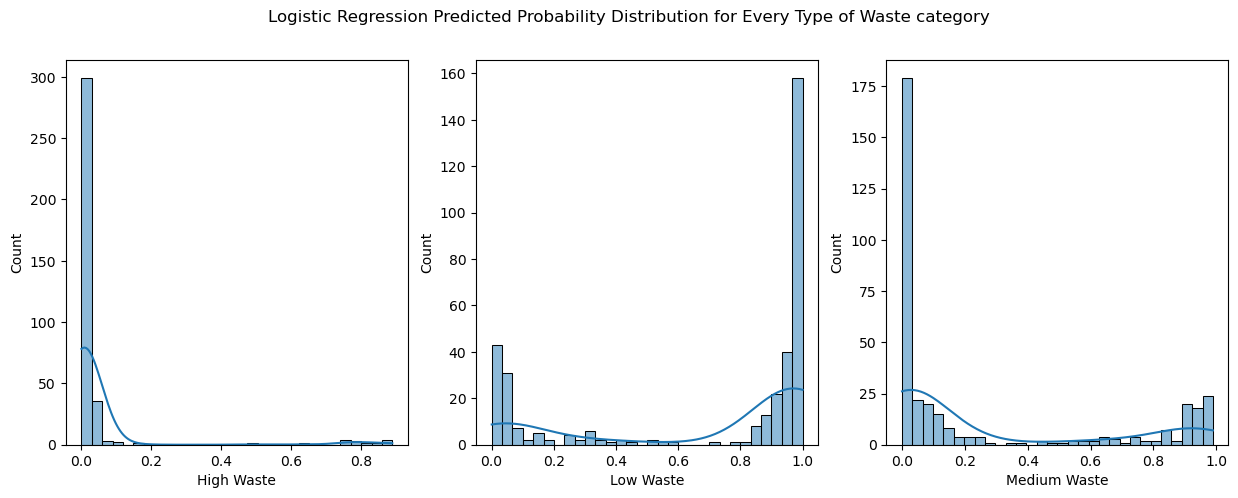

In [18]:
# Define a pipeline for logistic regression classification
lr_pipeline = Pipeline(steps=[
    ('Standardisation', Standardisation),  # Standardise the features
    ('classifier', LogisticRegression())  # Logistic Regression classifier
])

# Define the parameters
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization
    'classifier__penalty': ['l1', 'l2'],  # Penalty norm
    'classifier__solver': ['liblinear', 'saga']  # Optimization
}


# Use the grid option to configure the grid search.
grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='accuracy')

# Model fitting with grid search
grid_search_lr.fit(X_train, y_train)

# Print the optimal cross-validation score and optimal settings.
print("logistic regression Best parameters:", grid_search_lr.best_params_)
print("logistic regression Best cross-validation score: {:.3f}".format(grid_search_lr.best_score_))

# Calculate cross-validated accuracy
cross_val_acc_lr = cross_val_score(grid_search_lr, X, y, cv=10)
print("logistic regression Cross-validated Accuracy: {:.3f}".format(cross_val_acc_lr.mean()))

# Make a prediction using the test set
y_pred_lr = grid_search_lr.predict(X_test)


# Display classification report
print('\nlogistic regression Classification Report:')
print(classification_report(y_test, y_pred_lr))

# computing the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues', xticklabels=grid_search_lr.classes_, yticklabels=grid_search_lr.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('\nlogistic regression Confusion Matrix')
plt.show()

# Get the test set's predicted probability.
y_pred_proba_lr = grid_search_lr.predict_proba(X_test)

# Put the real labels and expected probabilities into a DataFrame.
pred_proba_df_lr = pd.DataFrame(y_pred_proba_lr, columns=grid_search_lr.classes_)

# Plot the predicted probability histograms for every class.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, class_label in enumerate(grid_search_lr.classes_):
    sns.histplot(pred_proba_df_lr[class_label], bins=30, ax=axes[i], kde=True)
    axes[i].set_xlabel(f'{class_label}')  # Set x-axis
    axes[i].set_ylabel('Count')  # Set y-axis
fig.suptitle('Logistic Regression Predicted Probability Distribution for Every Type of Waste category')  # Set title
plt.show()

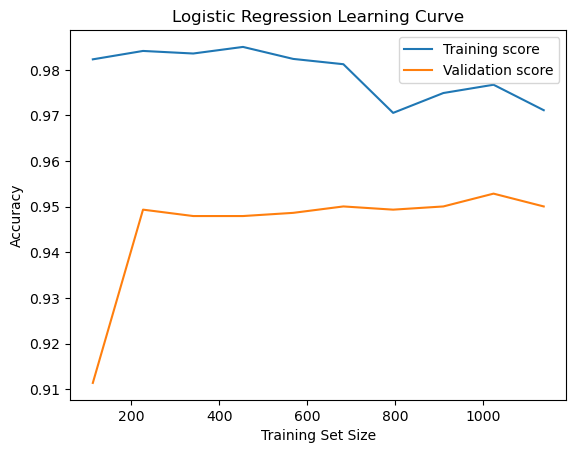

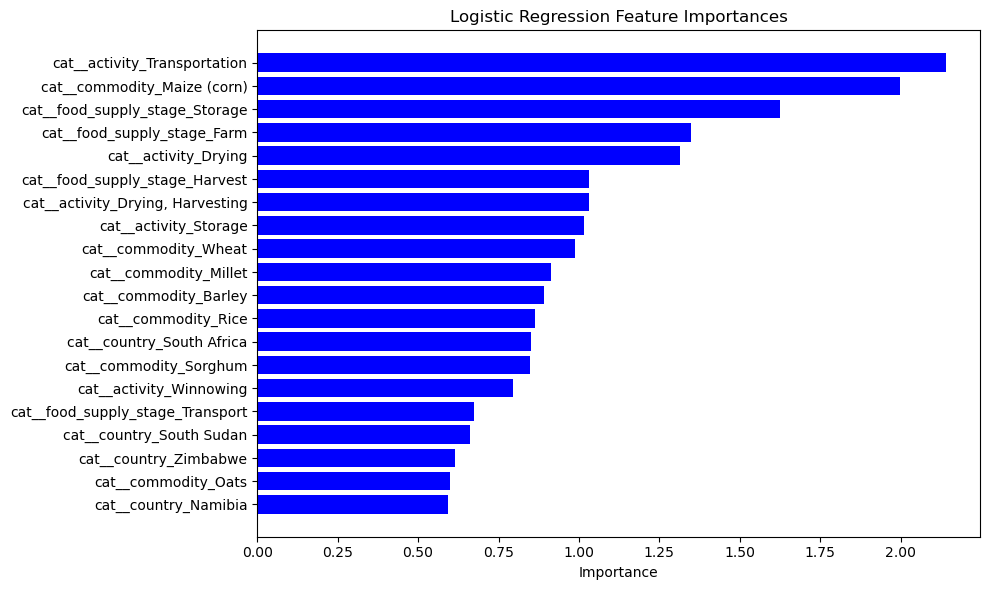

In [19]:
# Calculate learning curve
train_sizes_lr, training_scores_lr, validation_scores_lr = learning_curve(
    estimator=grid_search_lr.best_estimator_,
    X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy'
)

# Determine the scores' mean and standard deviation
train_mean_lr, train_std_lr = np.mean(training_scores_lr, axis=1), np.std(training_scores_lr, axis=1)
validation_mean_lr, validation_std_lr = np.mean(validation_scores_lr, axis=1), np.std(validation_scores_lr, axis=1)

# Plot learning curve
plt.plot(train_sizes_lr, train_mean_lr, label='Training score')
plt.plot(train_sizes_lr, validation_mean_lr, label='Validation score')

# Add title and labels
plt.title('Logistic Regression Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Get Coefficients from classifier
coefficients_lr = grid_search_lr.best_estimator_.named_steps['classifier'].coef_

# Obtain the names of features from the pipeline
features_lr = grid_search_lr.best_estimator_.named_steps['Standardisation'].get_feature_names_out()

importance_lr = np.abs(coefficients_lr).mean(axis=0)

# To obtain the indices of the most important features, sort the feature importances in descending order.
sorted_indices_lr = np.argsort(importance_lr)[::-1]

top_indices_lr = sorted_indices_lr[:20]

# Identify and prioritise the most important features.
best_feature_lr = features_lr[top_indices_lr]
best_importance_lr = importance_lr[top_indices_lr]

# Plot the feature significances.
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_indices_lr)), best_importance_lr, color='b', align='center')
plt.yticks(range(len(top_indices_lr)), best_feature_lr)
plt.gca().invert_yaxis()  # Flip the list so that the most crucial items are at the top.
plt.xlabel('Importance')
plt.title('Logistic Regression Feature Importances')
plt.tight_layout()
plt.show()

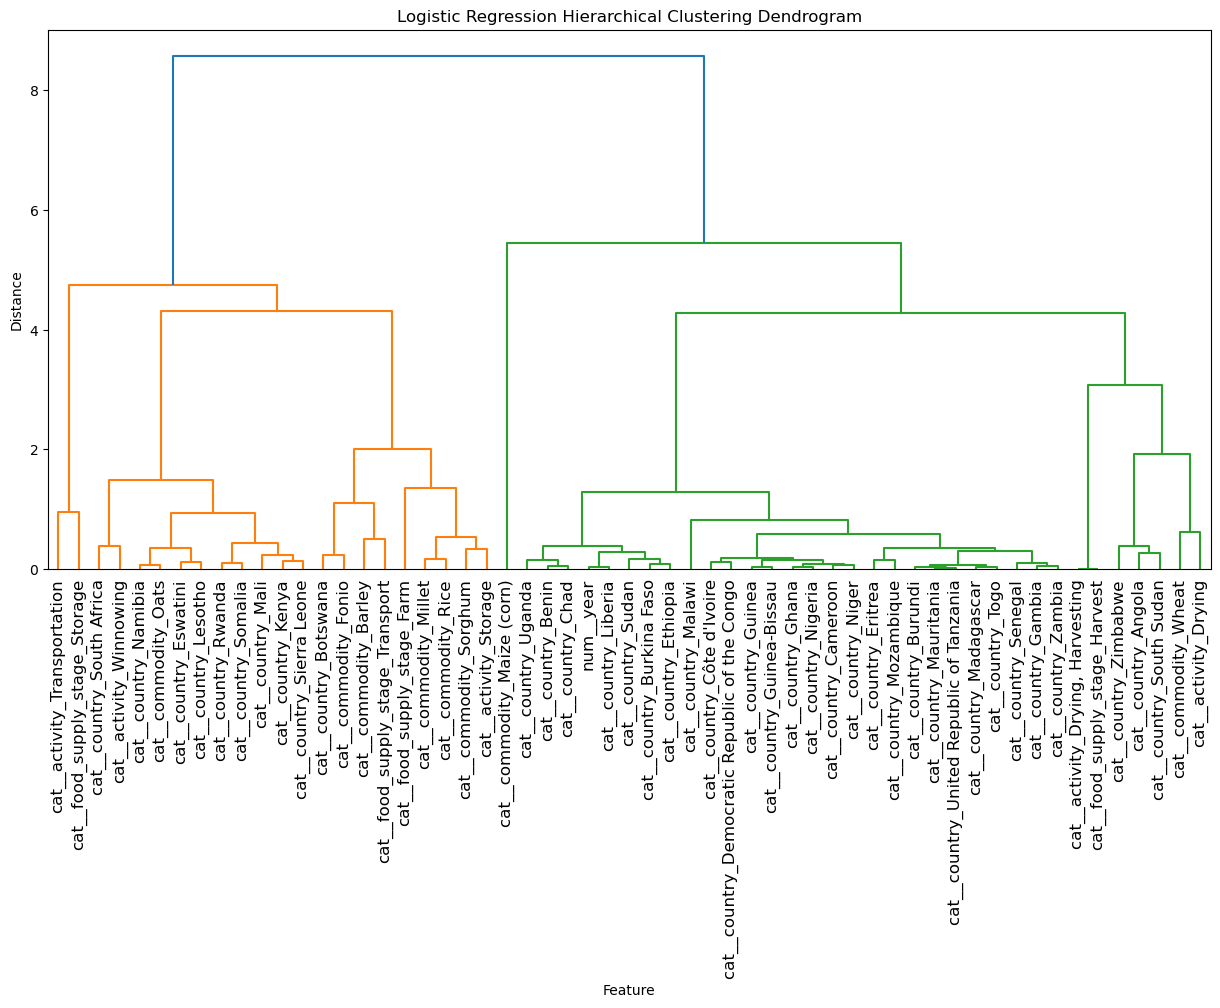

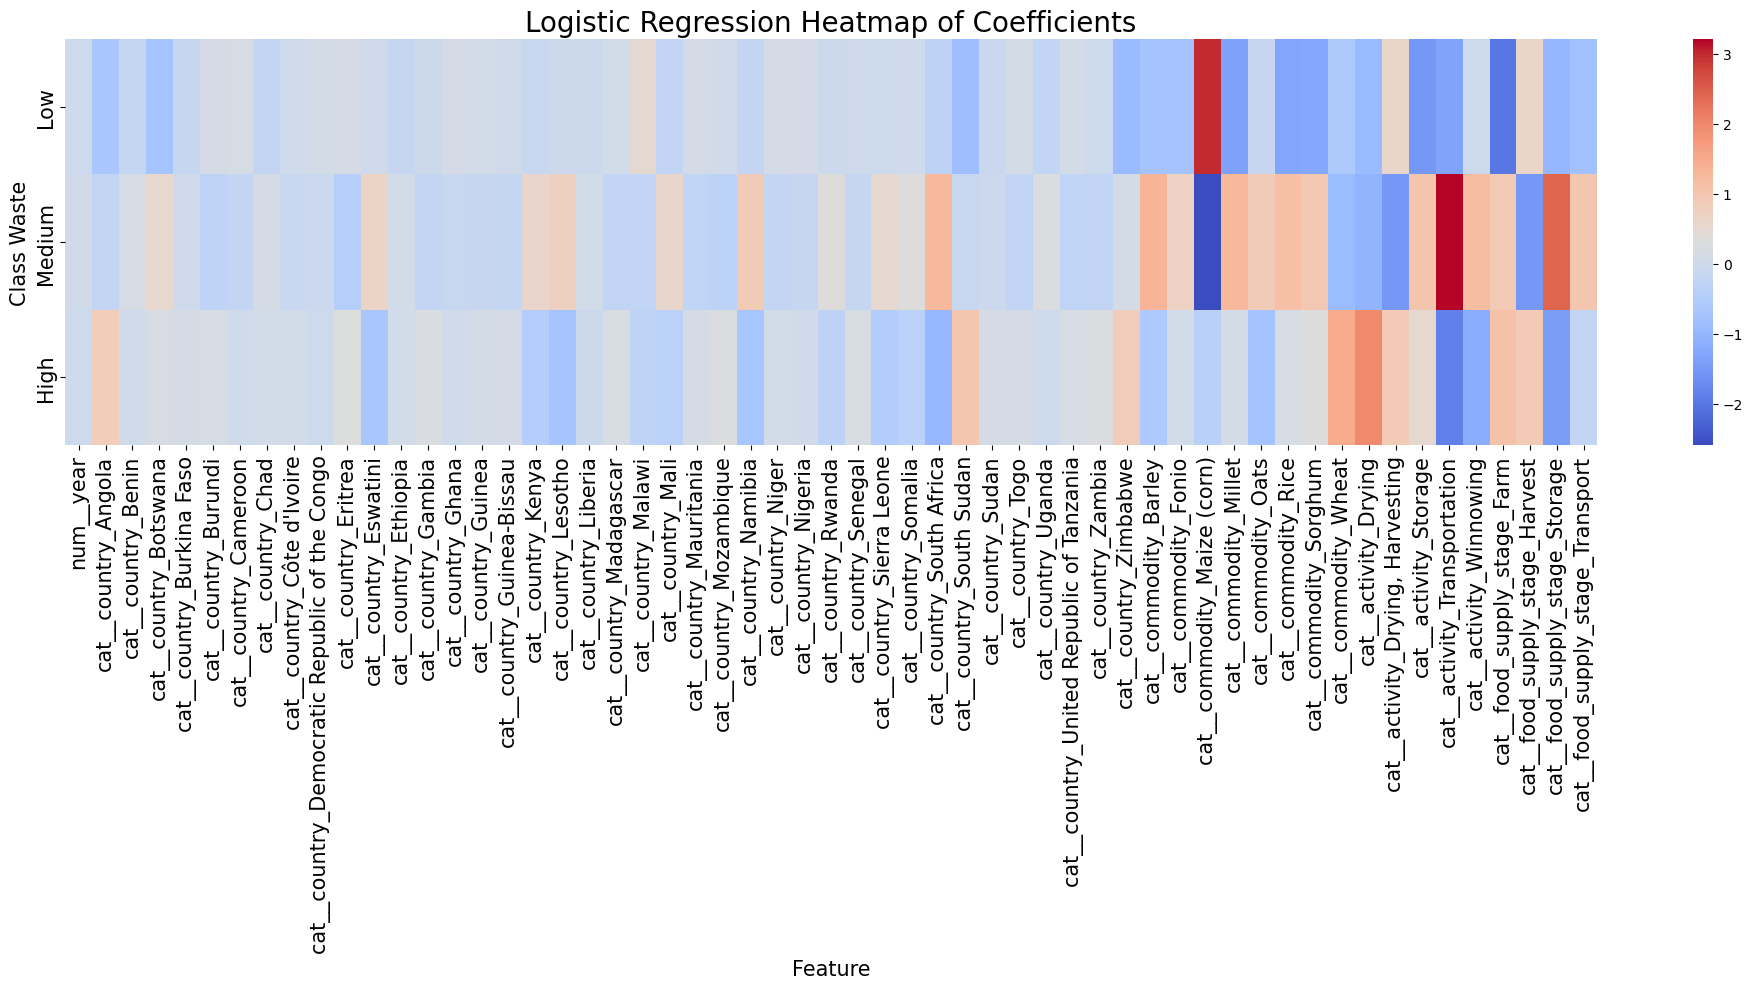

In [20]:
# Cluster the coefficients in a hierarchical structure
linked = linkage(coefficients_lr.T, method='ward')

# plot the dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linked, labels=features_lr, leaf_rotation=90, leaf_font_size=12)
plt.title('Logistic Regression Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.show()

# plot the heatmap
plt.figure(figsize=(20, 10))
ax = sns.heatmap(coefficients_lr, yticklabels=['Low', 'Medium', 'High'], xticklabels=features_lr, cmap='coolwarm')
plt.title('Logistic Regression Heatmap of Coefficients', fontsize=20)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Class Waste', fontsize=15)

# Make x labels easier to read
plt.xticks(rotation=90, fontsize=15)  # Rotate the x labels

# Make y labels easier to read
plt.yticks(fontsize=15) 
plt.tight_layout()  
plt.show()


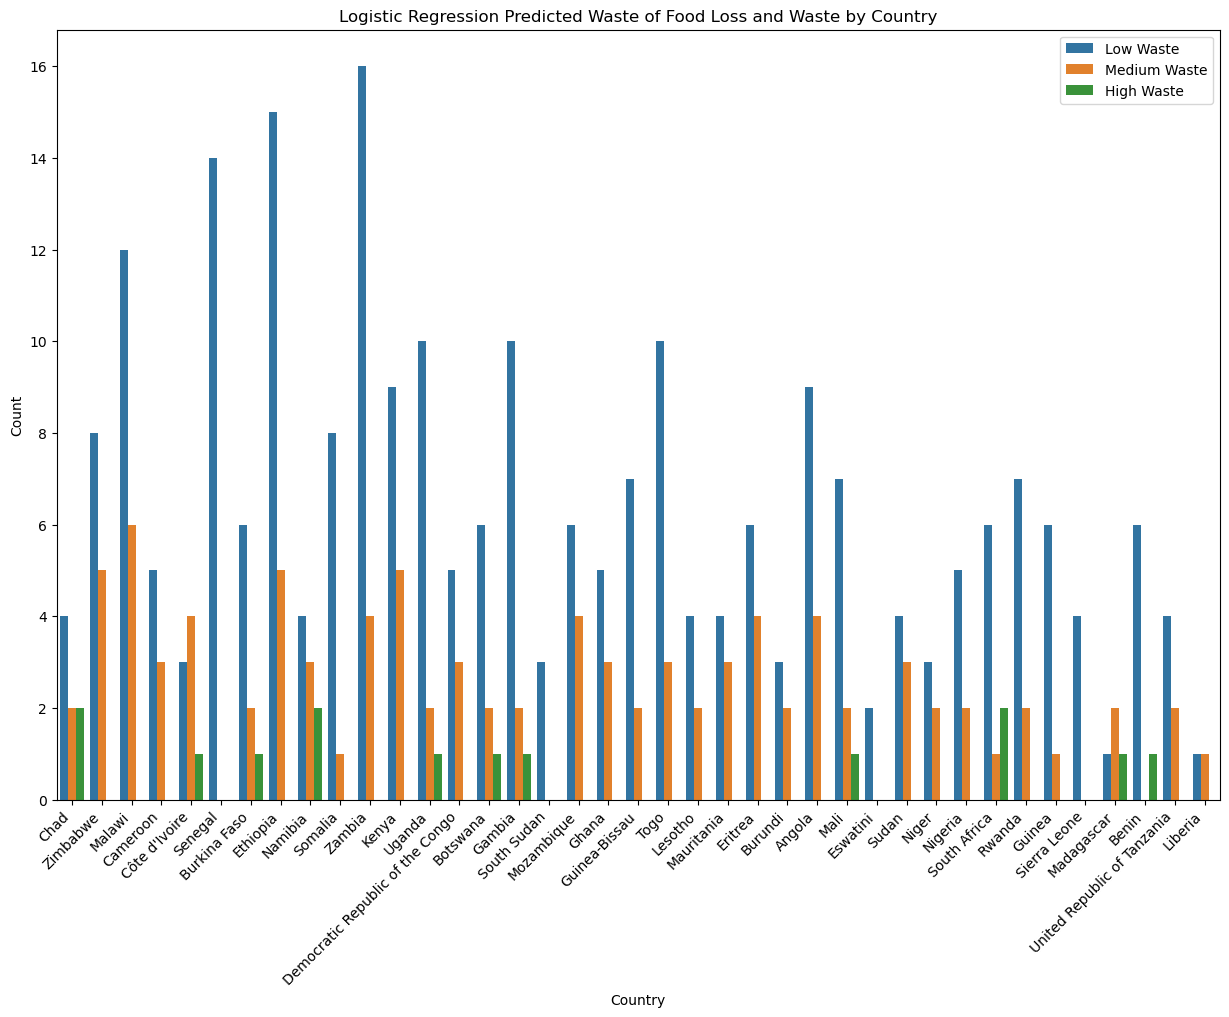

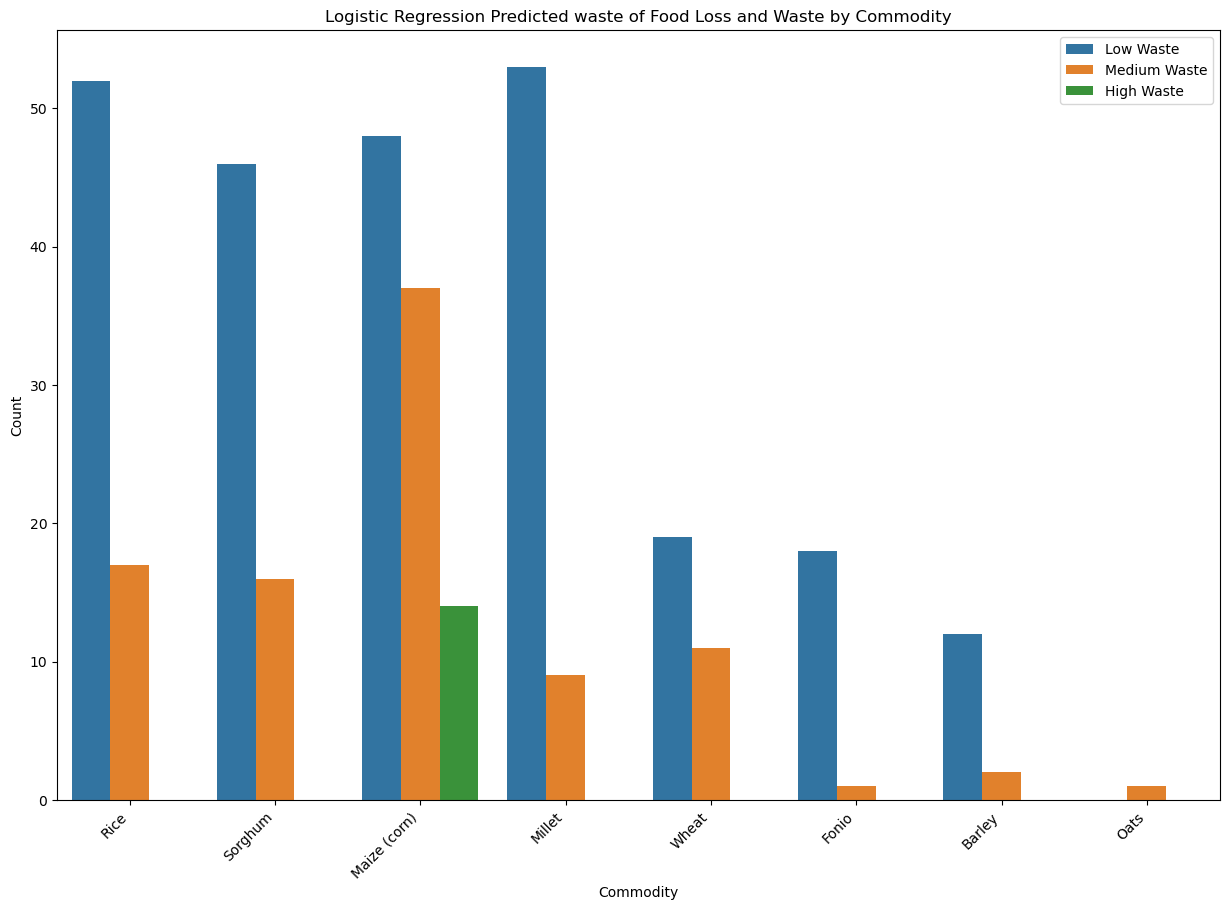

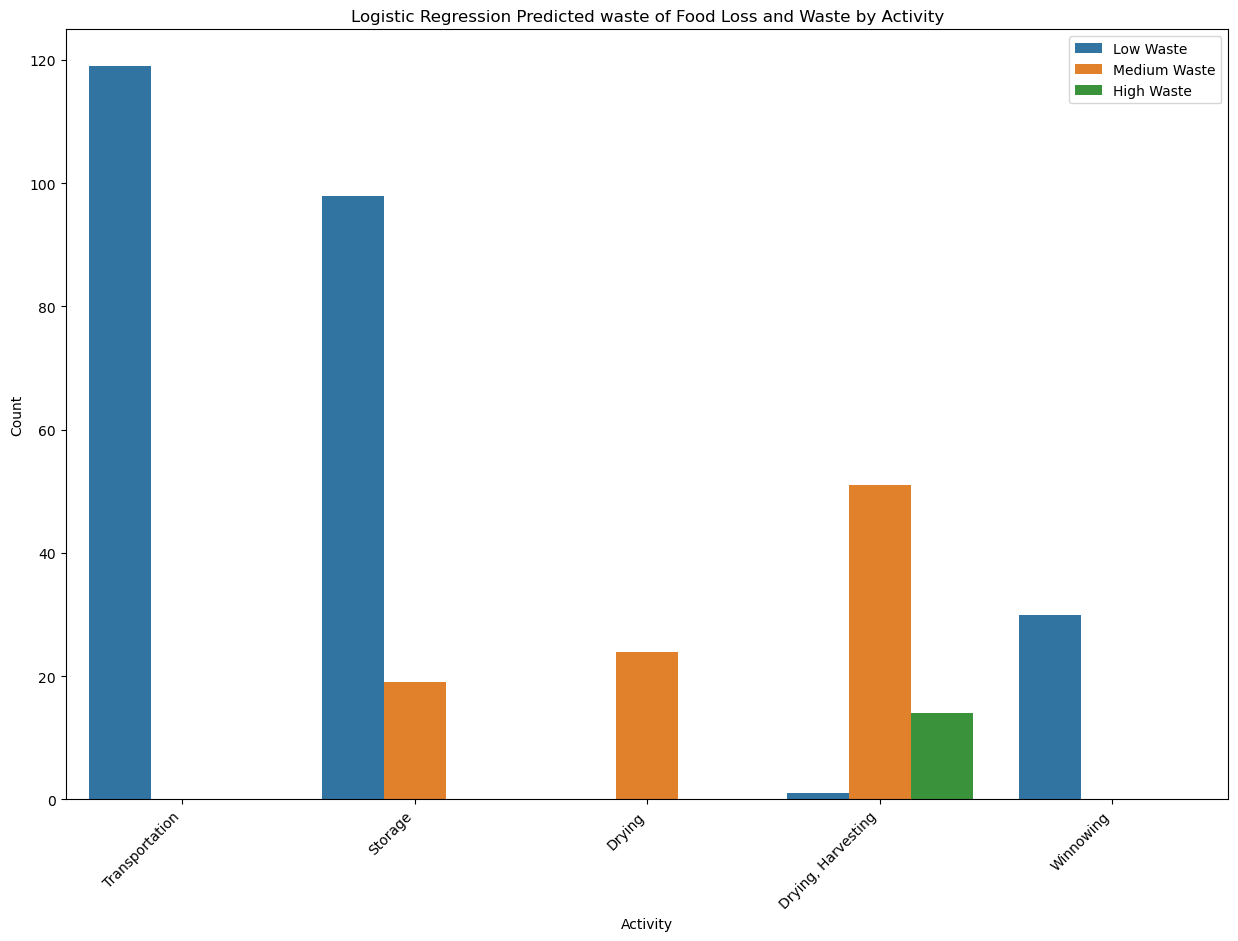

In [21]:
# Take a copy of the test attributes. DataFrame to maintain the test results next to the predictions
predictions_df_lr = X_test.copy()

# To the predictions_df DataFrame, add the waste types.
predictions_df_lr['predicted_waste_category'] = y_pred_lr

# Create a count plot showing the predicted waste by country
plt.figure(figsize=(15, 10))
sns.countplot(x='country', hue='predicted_waste_category', data=predictions_df_lr)
plt.title('Logistic Regression Predicted Waste of Food Loss and Waste by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Create a count plot showing the predicted waste by commodity
plt.figure(figsize=(15, 10))
sns.countplot(x='commodity', hue='predicted_waste_category', data=predictions_df_lr)
plt.title('Logistic Regression Predicted waste of Food Loss and Waste by Commodity')
plt.xlabel('Commodity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Create a count plot showing the predicted waste by activity
plt.figure(figsize=(15, 10))
sns.countplot(x='activity', hue='predicted_waste_category', data=predictions_df_lr)
plt.title('Logistic Regression Predicted waste of Food Loss and Waste by Activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Random Forest Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 400}
Random Forest Best cross-validation score: 0.969
Random Forest Cross-validated Accuracy: 0.955

Random Forest Classification Report:
              precision    recall  f1-score   support

  High Waste       0.60      1.00      0.75         9
   Low Waste       0.99      0.97      0.98       254
Medium Waste       0.92      0.91      0.92        93

    accuracy                           0.96       356
   macro avg       0.84      0.96      0.88       356
weighted avg       0.96      0.96      0.96       356



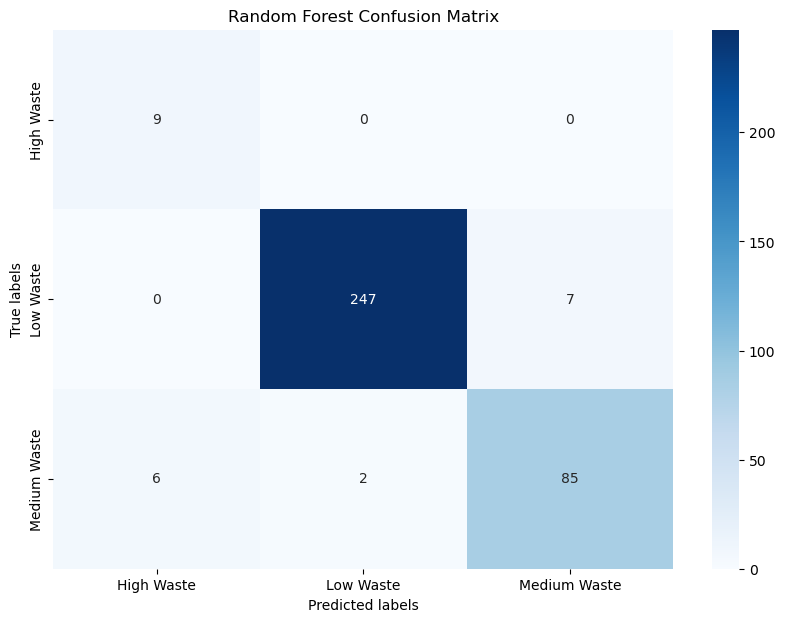

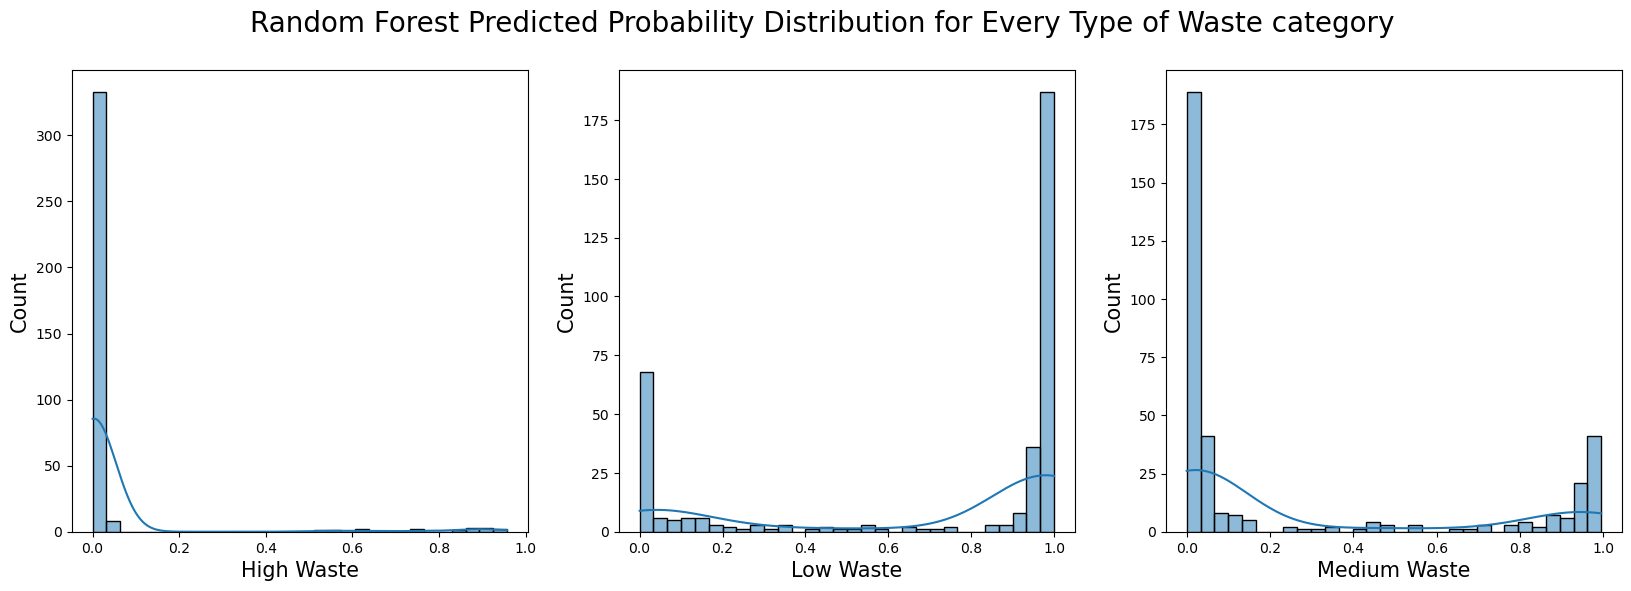

In [22]:
# Establish the pipeline for random forests
rf_pipeline = Pipeline(steps=[('Standardisation', Standardisation),
                              ('classifier', RandomForestClassifier())])

# Define the parameters
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 400],  # Number of trees
    'classifier__max_depth': [None, 10, 20],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5]  # The bare minimum of samples needed to divide an internal node
}

# Set up the random forest grid search.
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='accuracy')

# Model fitting
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Random Forest Best parameters:", grid_search_rf.best_params_)
print("Random Forest Best cross-validation score: {:.3f}".format(grid_search_rf.best_score_))

# Cross-validation accuracy
cross_val_acc_RF = cross_val_score(grid_search_rf, X, y, cv=10)
print("Random Forest Cross-validated Accuracy: {:.3f}".format(cross_val_acc_RF.mean()))

# Make a prediction using the test set
y_pred_rf = grid_search_rf.predict(X_test)

# Get the test set's predicted probability
y_pred_proba_rf = grid_search_rf.predict_proba(X_test)

# Display clasification report
print('\nRandom Forest Classification Report:') 
print(classification_report(y_test, y_pred_rf)) 

# Confusion Matrix Plot
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', xticklabels=grid_search_rf.classes_, yticklabels=grid_search_rf.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')
plt.show()
 
# Put the real labels and expected probabilities into a DataFrame.
pred_proba_df_rf = pd.DataFrame(y_pred_proba_rf, columns=grid_search_rf.classes_)

# Plot the predicted probability histograms for every class.
fig, axes = plt.subplots(nrows=1, ncols=len(grid_search_rf.classes_), figsize=(20, 6))
for i, class_label in enumerate(grid_search_rf.classes_):
    sns.histplot(pred_proba_df_rf[class_label], bins=30, ax=axes[i], kde=True)
    axes[i].set_xlabel(f'{class_label}', fontsize=15)
    axes[i].set_ylabel('Count', fontsize=15)
plt.suptitle('Random Forest Predicted Probability Distribution for Every Type of Waste category', fontsize=20)
plt.show()

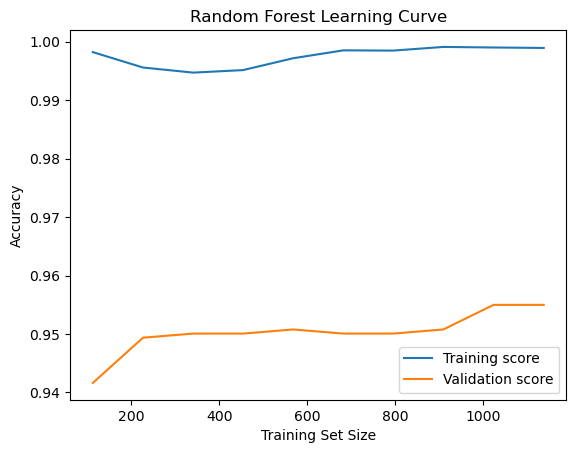

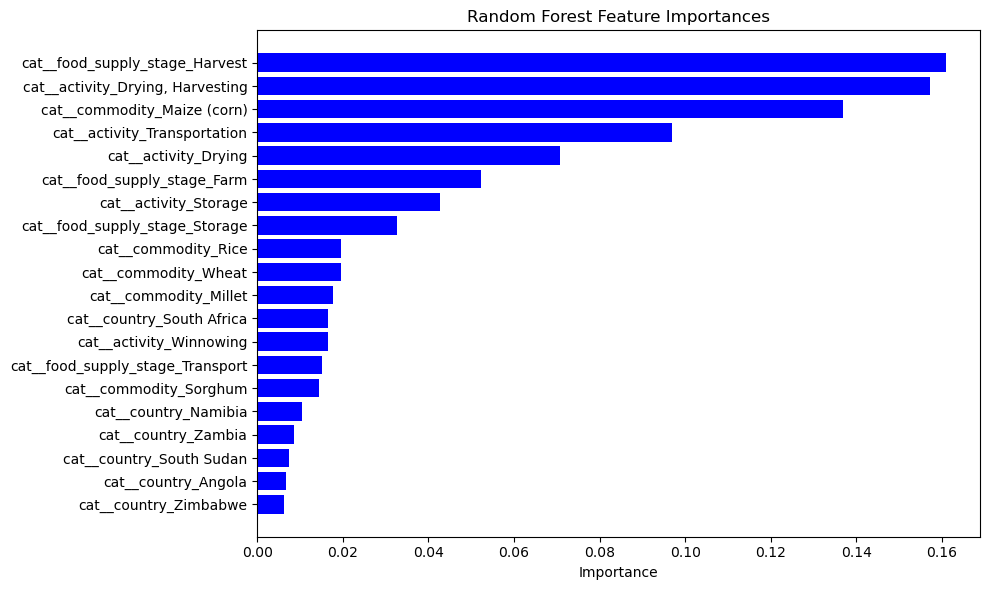

In [23]:
# Calculate learning curve
train_sizes_rf, training_scores_rf, validation_scores_rf = learning_curve(
    estimator=grid_search_rf.best_estimator_,
    X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy'
)

# Determine the scores' mean and standard deviation
train_mean_rf, train_std_rf = np.mean(training_scores_rf, axis=1), np.std(training_scores_rf, axis=1)
validation_mean_rf, validation_std_rf = np.mean(validation_scores_rf, axis=1), np.std(validation_scores_rf, axis=1)

# Plot learning curve
plt.plot(train_sizes_rf, train_mean_rf, label='Training score')
plt.plot(train_sizes_rf, validation_mean_rf, label='Validation score')

# Add title and labels
plt.title('Random Forest Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Use the best estimate to obtain feature importances
important_features_rf = grid_search_rf.best_estimator_.named_steps['classifier'].feature_importances_

# Arrange the feature priorities in a decreasing order
sorted_indices_rf = np.argsort(important_features_rf)[::-1]

# Obtain the top twenty indexes
top_indices_rf = sorted_indices_rf[:20]

# Obtain the names of the associated features.
features_rf = grid_search_rf.best_estimator_.named_steps['Standardisation'].get_feature_names_out()

# Obtain the names of the top features.
top_feature_rf = np.array(features_rf)[top_indices_rf]

# Plot the feature significances.
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importances')
plt.barh(range(len(top_indices_rf)), important_features_rf[top_indices_rf], color='b', align='center')
plt.yticks(range(len(top_indices_rf)), top_feature_rf)
plt.gca().invert_yaxis()  # Flip the list so that the most crucial items are at the top.
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


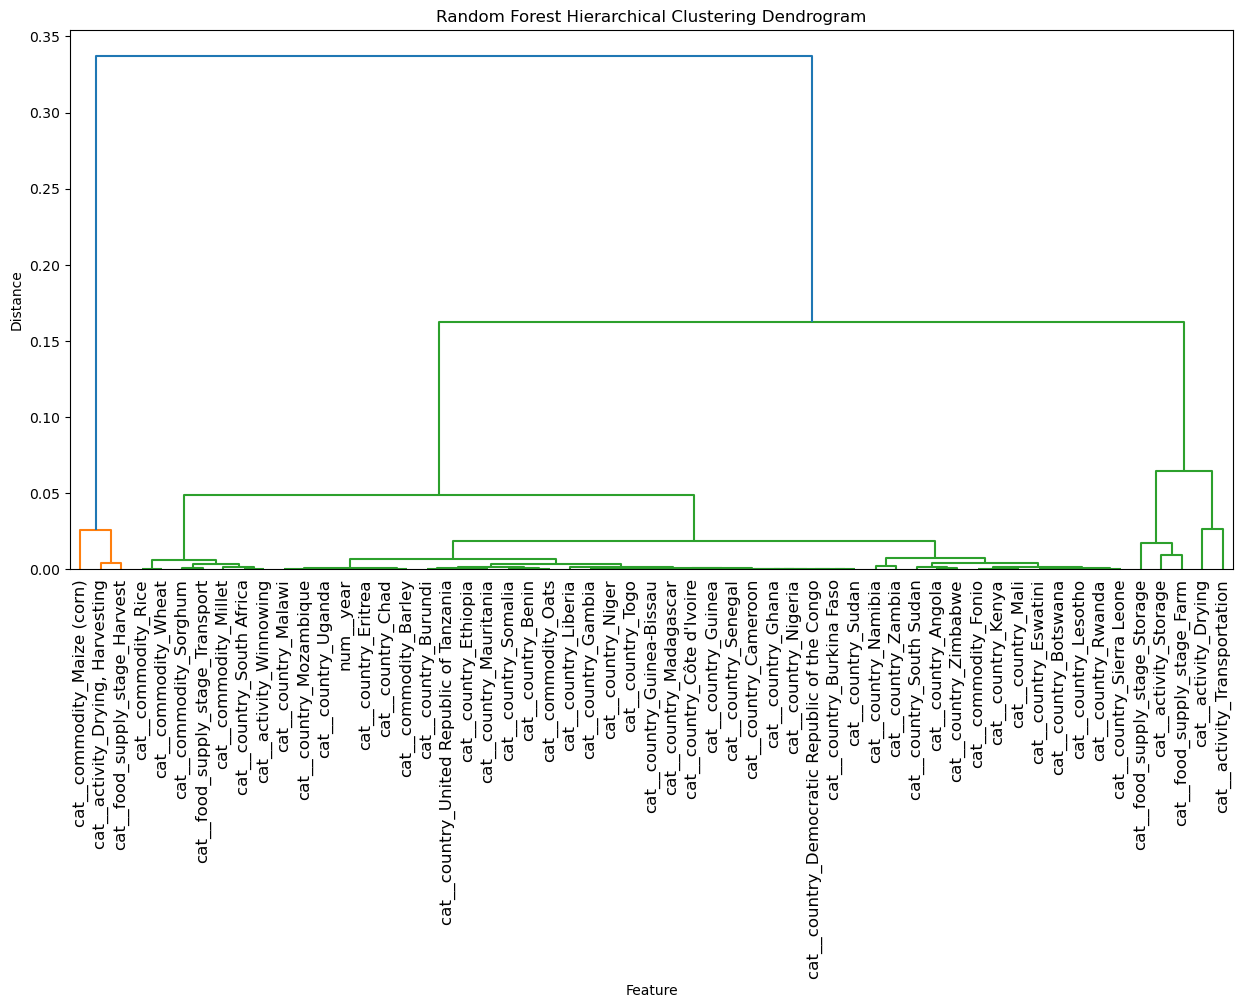

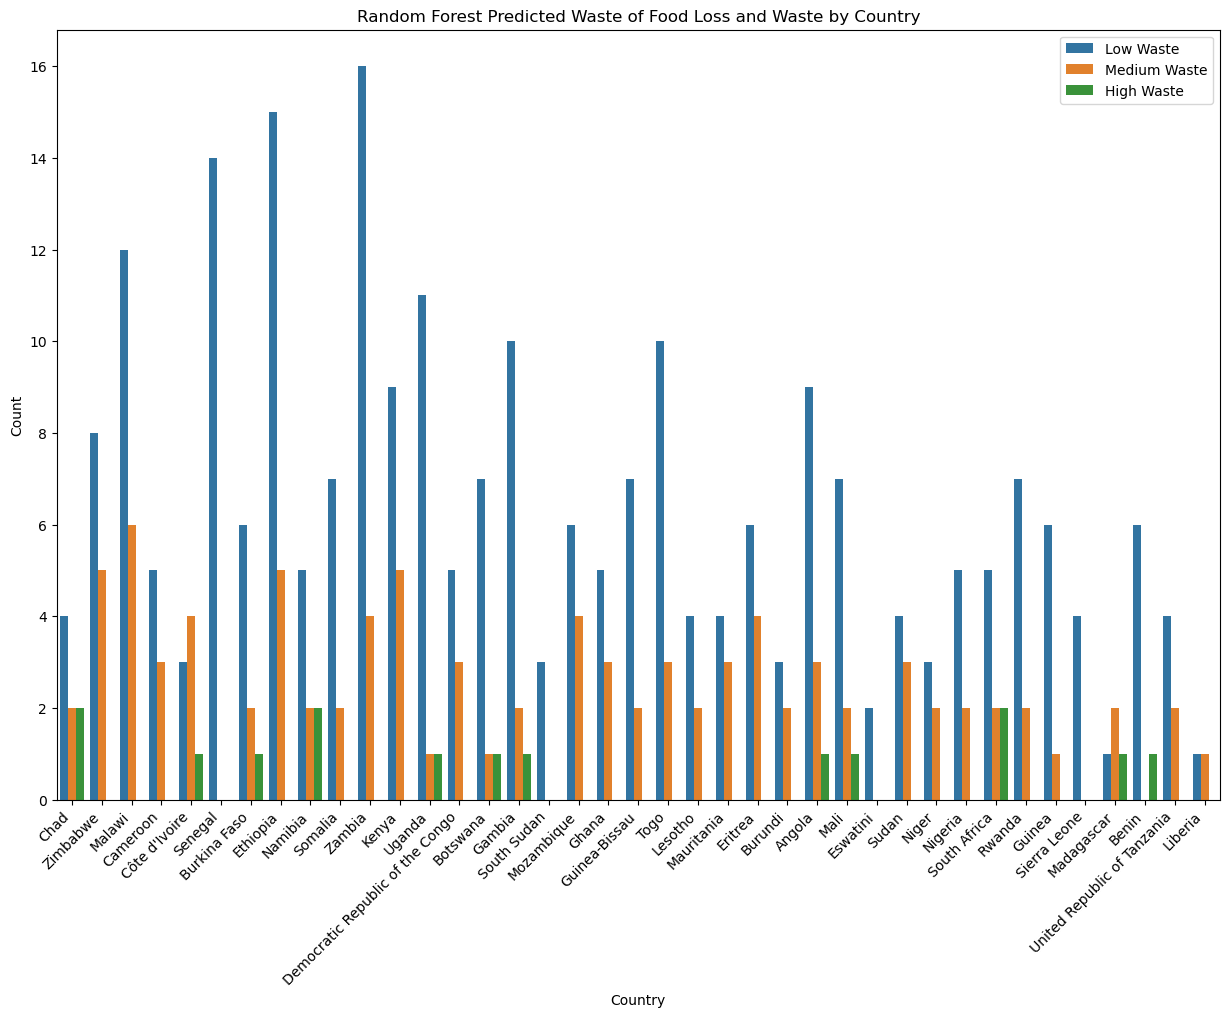

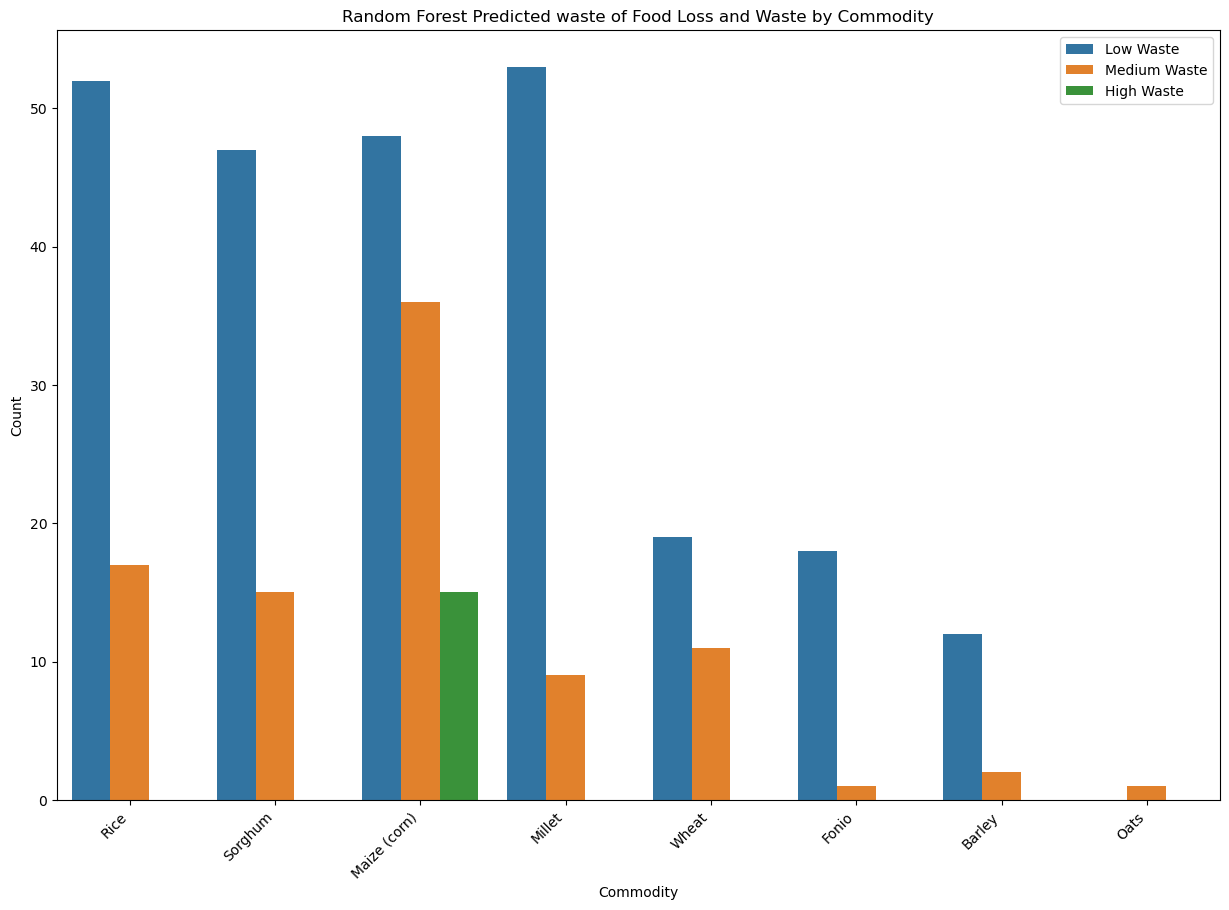

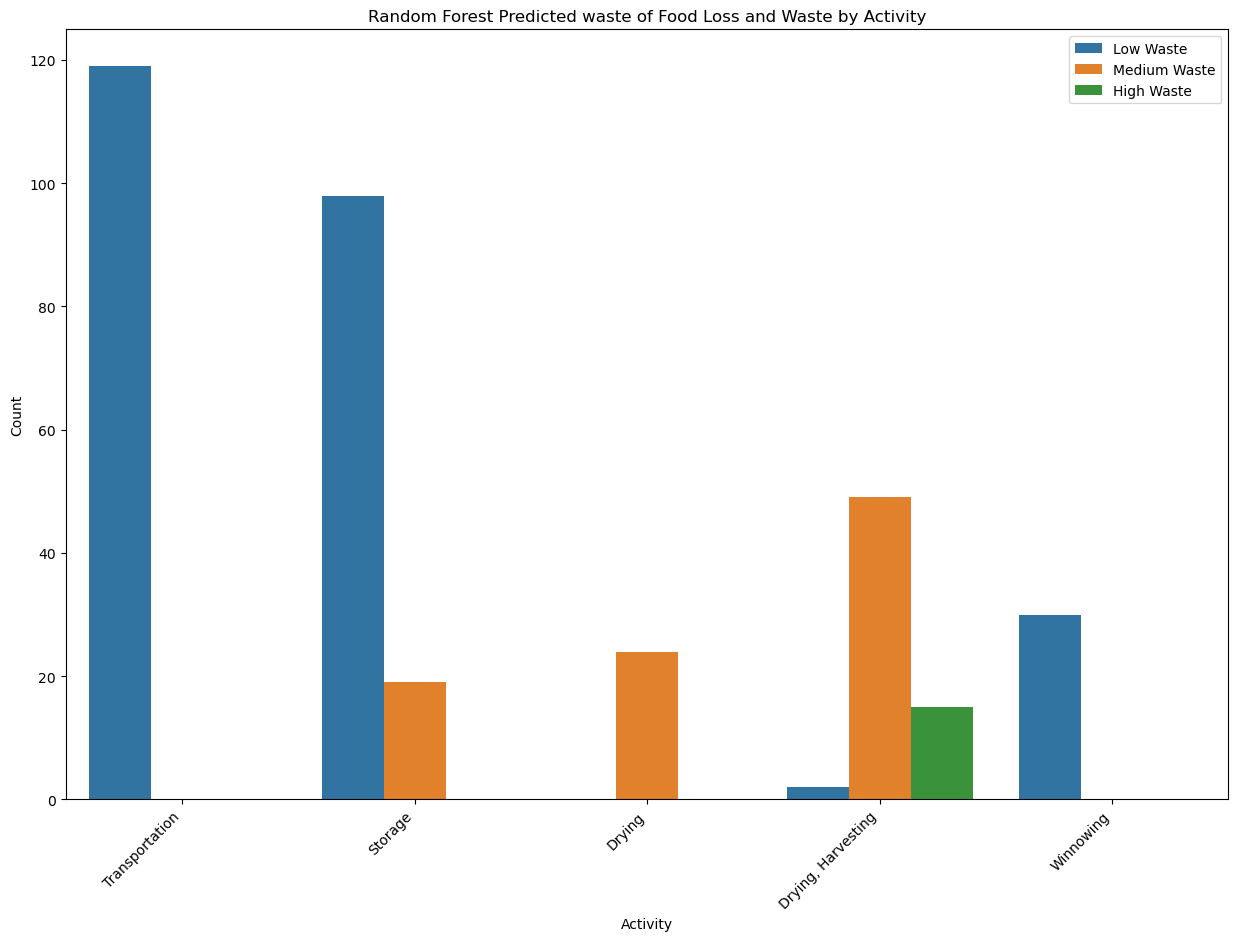

In [24]:
# Cluster features according to relevance using a hierarchical approach.
linked_rf = linkage(important_features_rf.reshape(-1, 1), method='ward')  

# Plot dendrogram for the significance of Random Forest features
plt.figure(figsize=(15, 7))  
dendrogram(linked_rf, labels=features_rf, leaf_rotation=90, leaf_font_size=12) 
plt.title('Random Forest Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.show()

# Take a copy of the test attributes. DataFrame to maintain the test results next to the predictions
predictions_df_rf = X_test.copy()

# To the predictions_df DataFrame, add the waste types.
predictions_df_rf['predicted_waste_category'] = y_pred_rf

# Create a count plot showing the predicted waste by country
plt.figure(figsize=(15, 10))
sns.countplot(x='country', hue='predicted_waste_category', data=predictions_df_rf)
plt.title('Random Forest Predicted Waste of Food Loss and Waste by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Create a count plot showing the predicted waste by commodity
plt.figure(figsize=(15, 10))
sns.countplot(x='commodity', hue='predicted_waste_category', data=predictions_df_rf)
plt.title('Random Forest Predicted waste of Food Loss and Waste by Commodity')
plt.xlabel('Commodity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Create a count plot showing the predicted waste by activity
plt.figure(figsize=(15, 10))
sns.countplot(x='activity', hue='predicted_waste_category', data=predictions_df_rf)
plt.title('Random Forest Predicted waste of Food Loss and Waste by Activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Gradient Boosting Best parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Gradient Boosting Best cross-validation score: 0.98
Gradient Boosting Cross-validated Accuracy: 0.96

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

  High Waste       0.69      1.00      0.82         9
   Low Waste       1.00      0.98      0.99       254
Medium Waste       0.96      0.96      0.96        93

    accuracy                           0.98       356
   macro avg       0.88      0.98      0.92       356
weighted avg       0.98      0.98      0.98       356



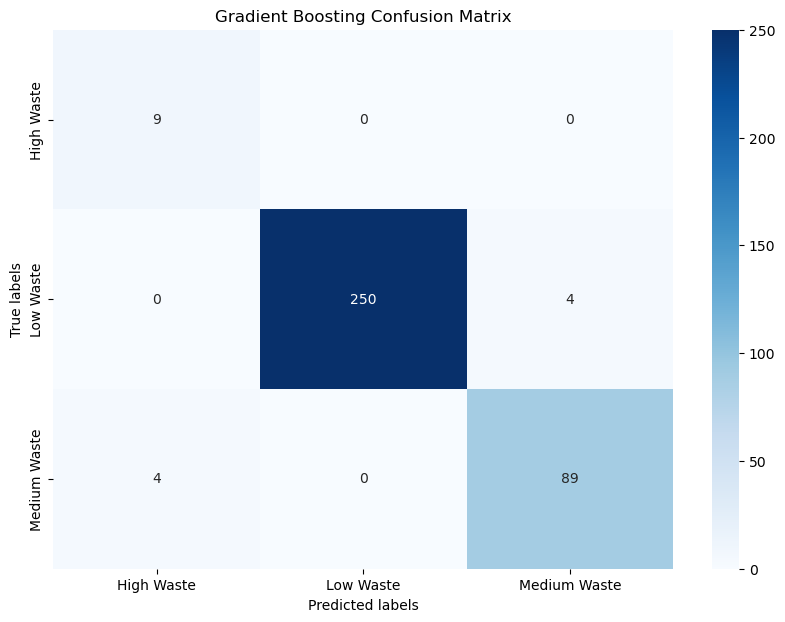

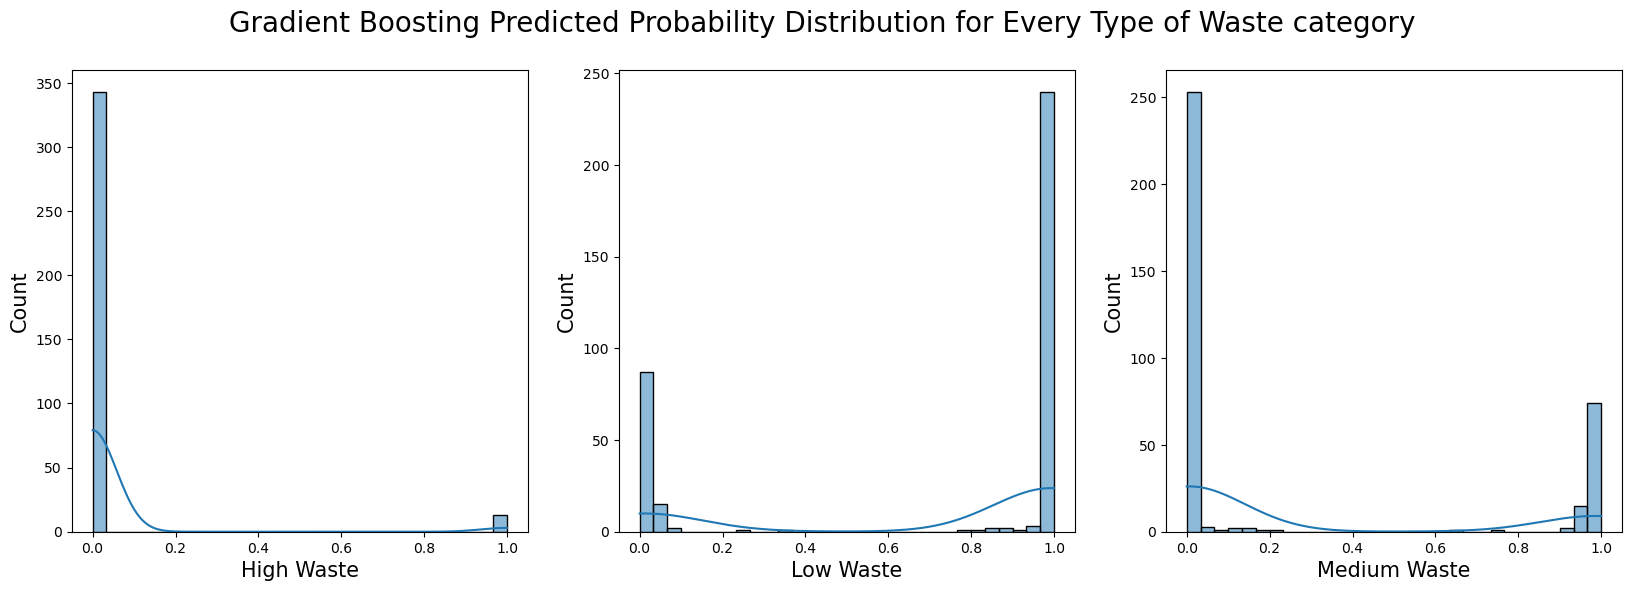

In [25]:
# Create the gradient boosting pipeline
gb_pipeline = Pipeline(steps=[('Standardisation', Standardisation),
                              ('classifier', GradientBoostingClassifier())])

# Define the parameters
param_grid_gb = {
    'classifier__n_estimators': [64, 100, 200],  # Number of boosting stages
    'classifier__learning_rate': [0.05, 0.075, 0.1],  # Learning rate
    'classifier__max_depth': [3, 5]  # Maximum depth for each regression estimator separately
}

# Configure the grid search for gradients boost 
grid_search_gb = GridSearchCV(gb_pipeline, param_grid_gb, cv=5, scoring='accuracy')

# Model fitting
grid_search_gb.fit(X_train, y_train)

# Best parameters and best score
print("Gradient Boosting Best parameters:", grid_search_gb.best_params_)
print("Gradient Boosting Best cross-validation score: {:.2f}".format(grid_search_gb.best_score_))

# Cross-validation accuracy
cross_val_acc_gb = cross_val_score(grid_search_gb, X, y, cv=10)
print("Gradient Boosting Cross-validated Accuracy: {:.2f}".format(cross_val_acc_gb.mean()))

# Make a prediction using the test set
y_pred_gb = grid_search_gb.predict(X_test)

 
# Display Classification report
print('\nGradient Boosting Classification Report:') 
print(classification_report(y_test, y_pred_gb)) 

# Plot the Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_gb, annot=True, fmt='g', cmap='Blues', xticklabels=grid_search_gb.classes_, yticklabels=grid_search_gb.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Gradient Boosting Confusion Matrix')
plt.show()

# Obtain the test set's predicted probability.
y_pred_proba_gb = grid_search_gb.predict_proba(X_test)

# Put the real labels and expected probabilities into a DataFrame.
pred_proba_df_gb = pd.DataFrame(y_pred_proba_gb, columns=grid_search_gb.classes_)

# Plot the predicted probability histograms for every class.
fig, axes = plt.subplots(nrows=1, ncols=len(grid_search_gb.classes_), figsize=(20, 6))
for i, class_label in enumerate(grid_search_gb.classes_):
    sns.histplot(pred_proba_df_gb[class_label], bins=30, ax=axes[i], kde=True)
    axes[i].set_xlabel(f'{class_label}', fontsize=15)
    axes[i].set_ylabel('Count', fontsize=15)
fig.suptitle('Gradient Boosting Predicted Probability Distribution for Every Type of Waste category', fontsize=20)
plt.show()

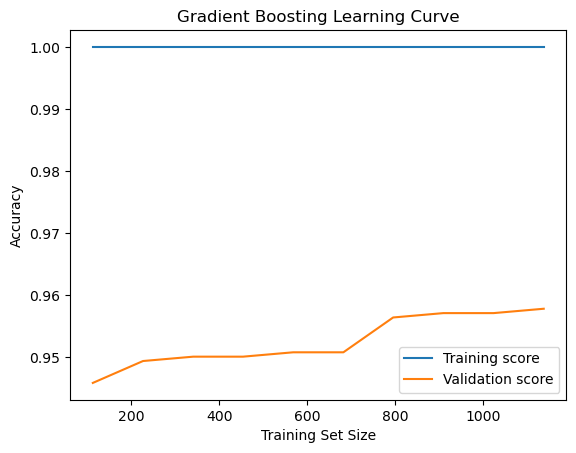

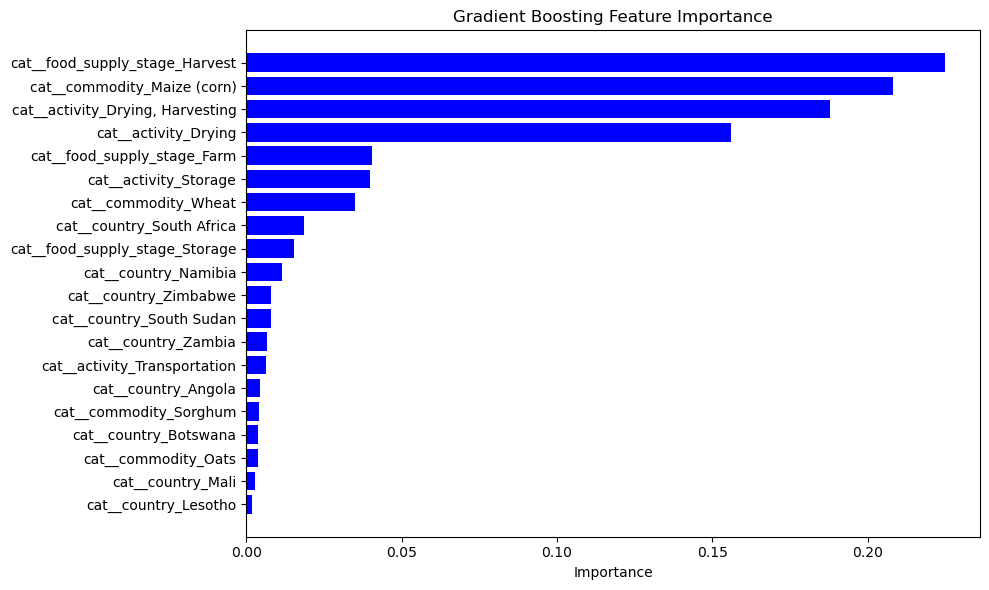

In [26]:
# Calculate learning curve
train_sizes_gb, training_scores_gb, validation_scores_gb = learning_curve(
    estimator=grid_search_gb.best_estimator_,
    X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy'
)

# Determine the scores' mean and standard deviation
train_mean_gb, train_std_gb = np.mean(training_scores_gb, axis=1), np.std(training_scores_gb, axis=1)
validation_mean_gb, validation_std_gb = np.mean(validation_scores_gb, axis=1), np.std(validation_scores_gb, axis=1)

# Plot learning curve
plt.plot(train_sizes_gb, train_mean_gb, label='Training score')
plt.plot(train_sizes_gb, validation_mean_gb, label='Validation score')

# Add title and labels
plt.title('Gradient Boosting Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Assuming 'grid_search_gb.best_estimator_.named_steps["classifier"]' gives the Gradient Boosting Classifier
feature_importances_gb = grid_search_gb.best_estimator_.named_steps["classifier"].feature_importances_

# Arrange the feature priorities in a decreasing order
indices_gb = np.argsort(feature_importances_gb)[::-1]

# Top 20 features
top_indices_gb = indices_gb[:20] 

# Obtain the names of the associated features.
features_gb = grid_search_gb.best_estimator_.named_steps['Standardisation'].get_feature_names_out()

# Obtain the names of the top features.
top_feature_gb = np.array(features_gb)[top_indices_gb]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Gradient Boosting Feature Importance")
plt.barh(range(len(top_indices_gb)), feature_importances_gb[top_indices_gb], color="b", align="center")
plt.yticks(range(len(top_indices_gb)), top_feature_gb)
plt.gca().invert_yaxis()  # Flip the list so that the most crucial items are at the top.
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


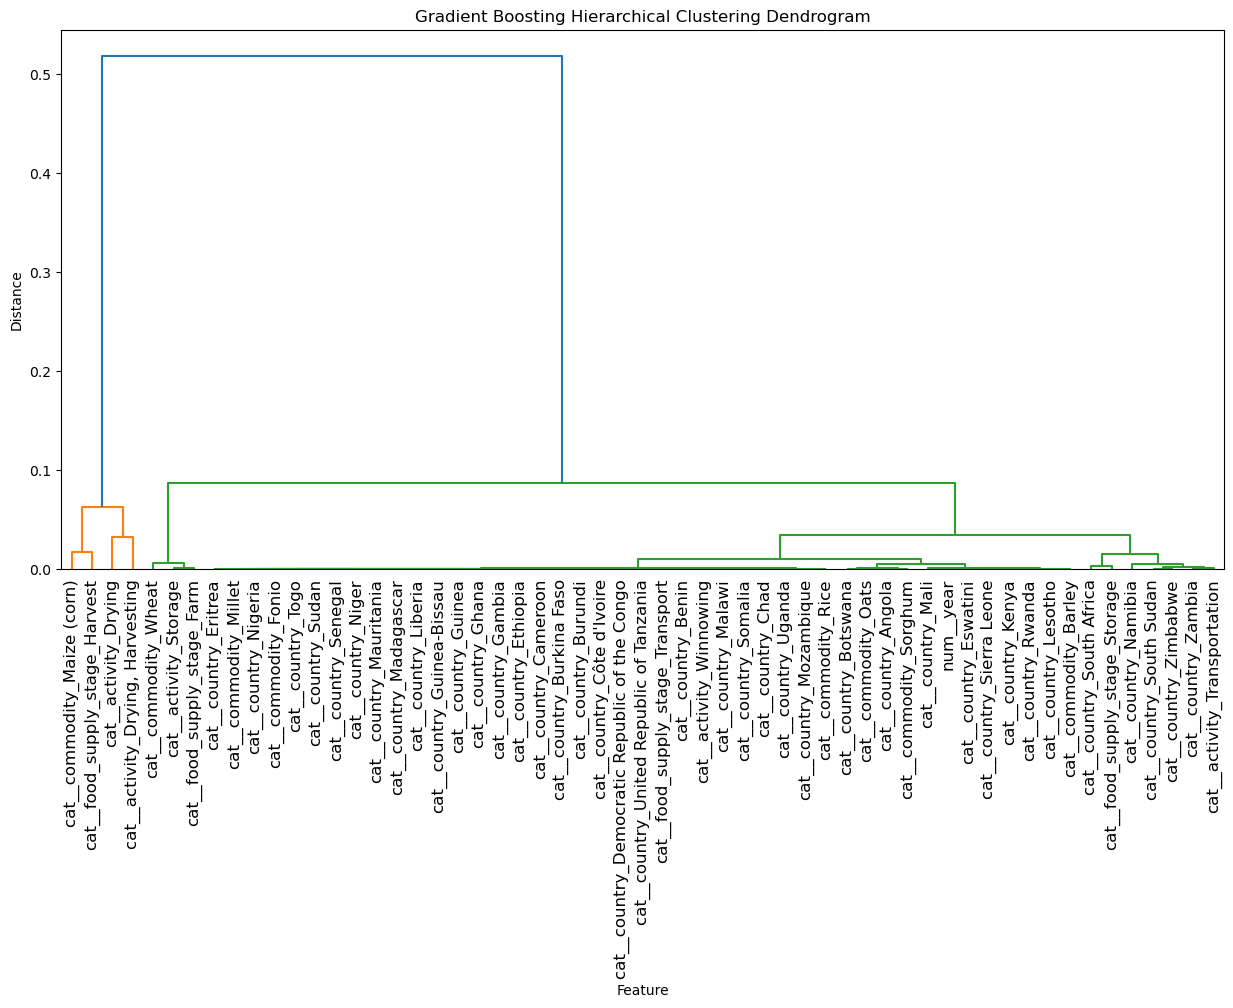

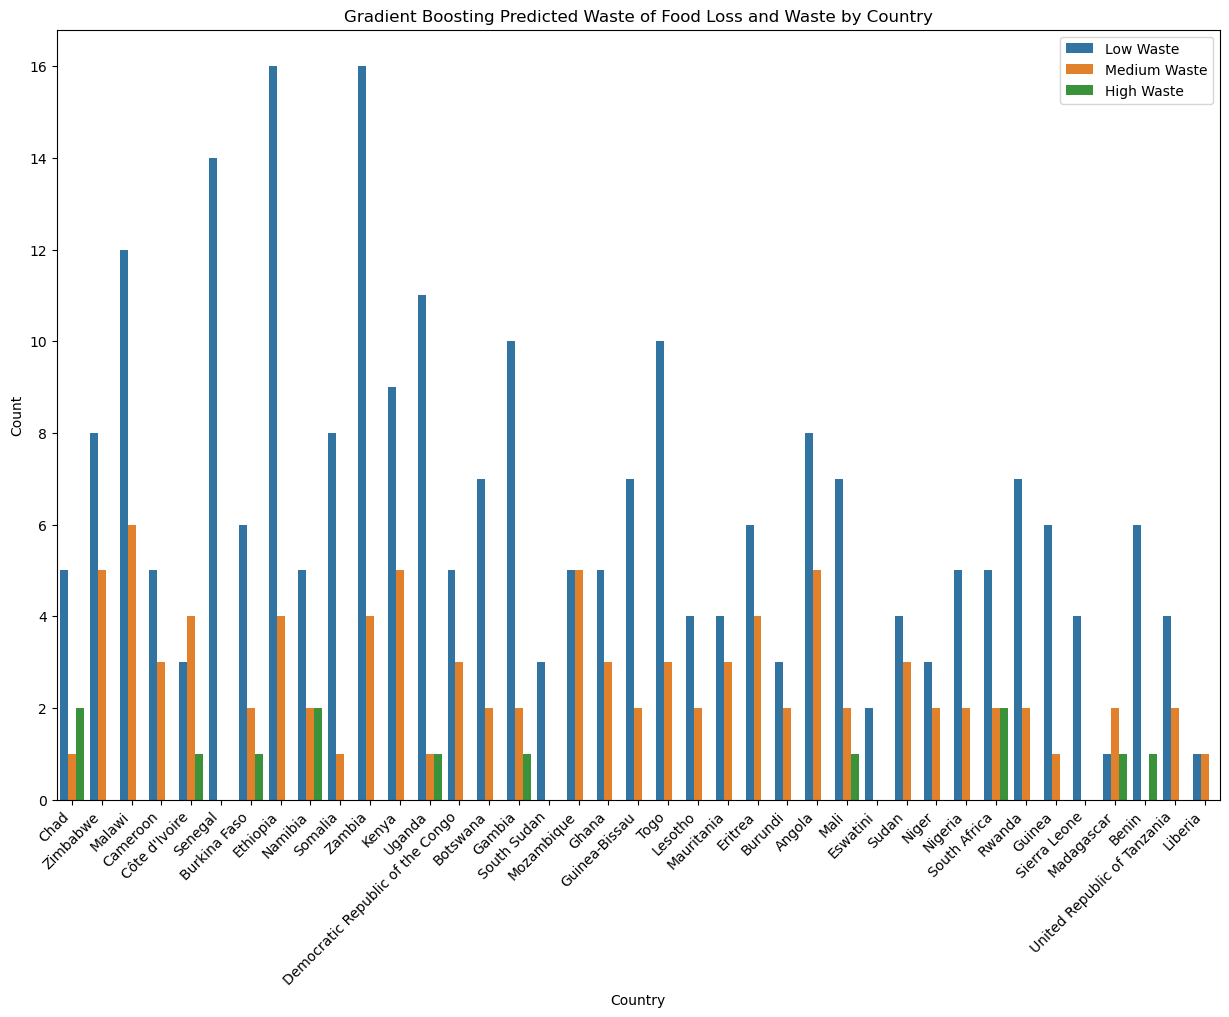

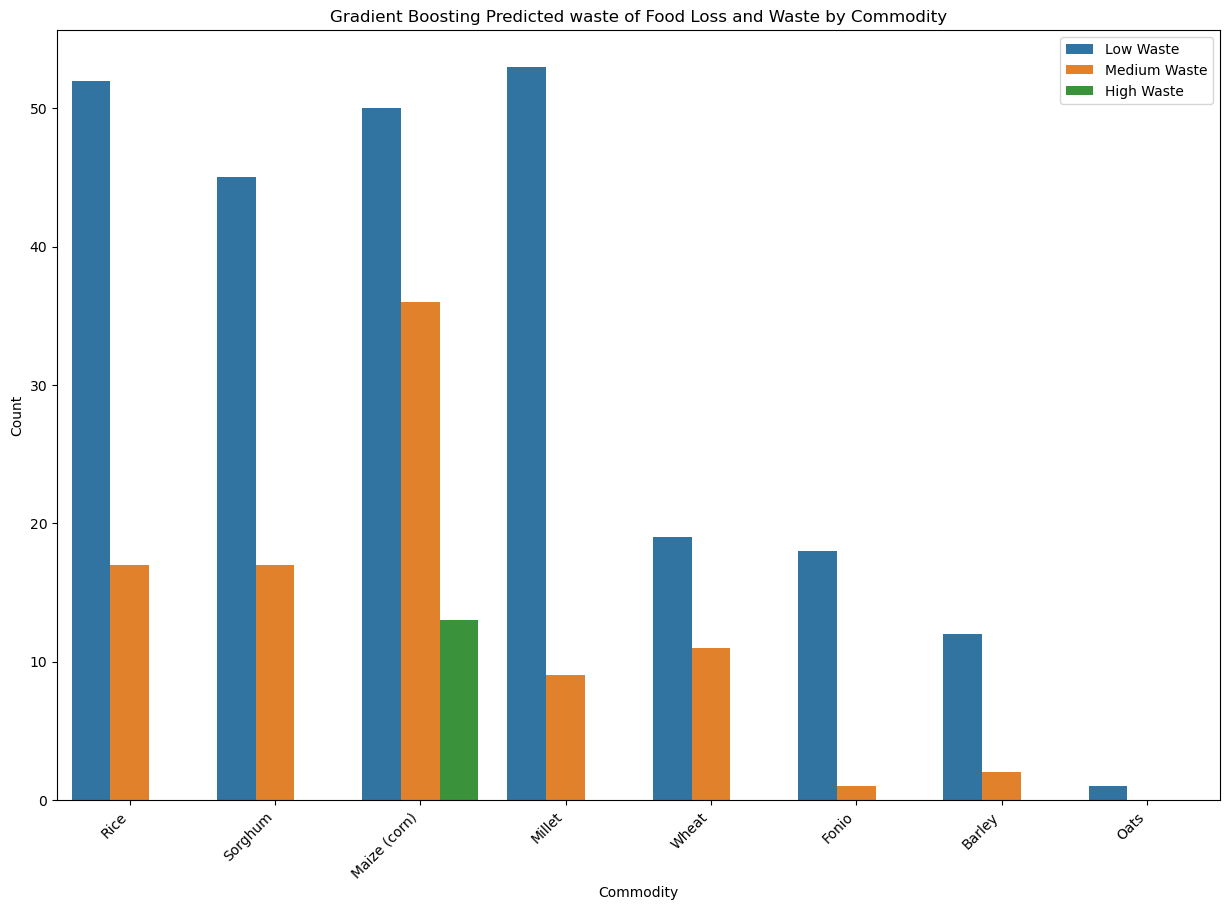

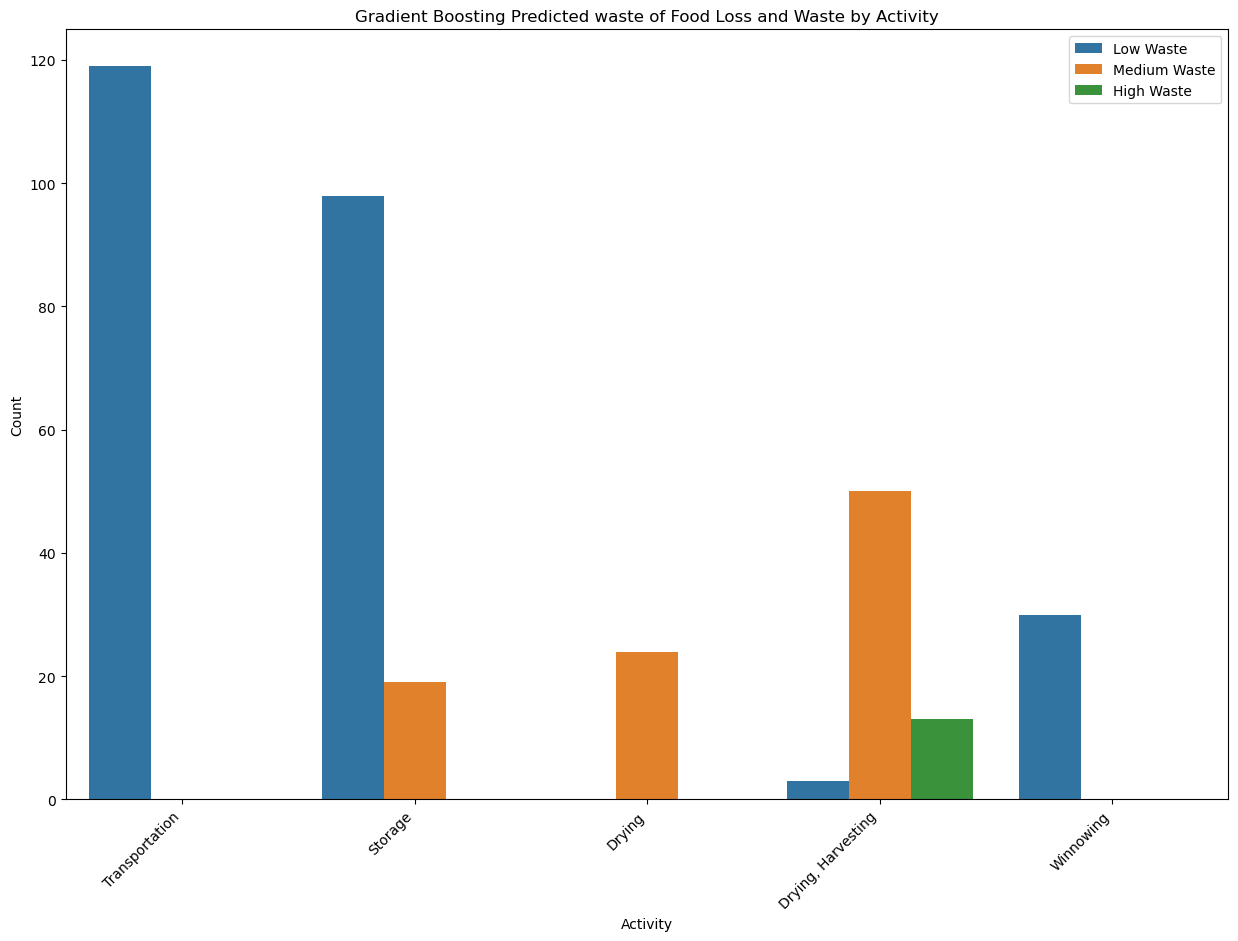

In [27]:
# Cluster features according to relevance using a hierarchical approach.
linked_gb = linkage(feature_importances_gb.reshape(-1, 1), 'ward')

# Plot dendrogram for the significance of GB features
plt.figure(figsize=(15, 7))
dendrogram(linked_gb, labels=features_gb, leaf_rotation=90, leaf_font_size=12)
plt.title('Gradient Boosting Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.show()

# Take a copy of the test attributes. DataFrame to maintain the test results next to the predictions
predictions_df_gb = X_test.copy()

# To the predictions_df DataFrame, add the waste types.
predictions_df_gb['predicted_waste_category'] = y_pred_gb

# Create a count plot showing the predicted waste by country
plt.figure(figsize=(15, 10))
sns.countplot(x='country', hue='predicted_waste_category', data=predictions_df_gb)
plt.title('Gradient Boosting Predicted Waste of Food Loss and Waste by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Create a count plot showing the predicted waste by commodity
plt.figure(figsize=(15, 10))
sns.countplot(x='commodity', hue='predicted_waste_category', data=predictions_df_gb)
plt.title('Gradient Boosting Predicted waste of Food Loss and Waste by Commodity')
plt.xlabel('Commodity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Create a count plot showing the predicted waste by activity
plt.figure(figsize=(15, 10))
sns.countplot(x='activity', hue='predicted_waste_category', data=predictions_df_gb)
plt.title('Gradient Boosting Predicted waste of Food Loss and Waste by Activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Neural Network Top Hyperparameters: {'learning_rate': 0.0001, 'hidden_neurons': 25, 'epochs': 5000}
Neural Network Top Validation Accuracy: 0.919


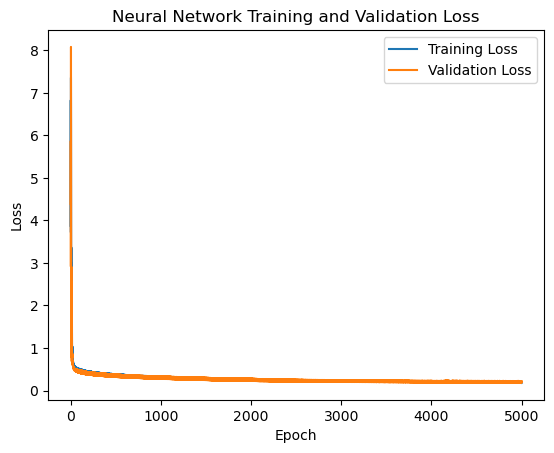

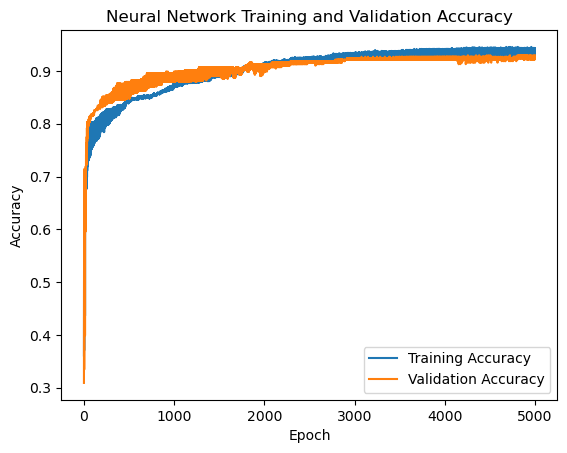

In [18]:
# Initialize OrdinalEncoder
encoder = OrdinalEncoder()

# Encode categorical features
X = encoder.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Function to set the neural network's starting parameters
def initialize_parameters(input_neurons, hidden_neurons, output_neurons):
    np.random.seed(42)
    return {
        "weight1": np.random.randn(hidden_neurons, input_neurons) * np.sqrt(2. / input_neurons),
        "biase1": np.zeros((hidden_neurons, 1)),
        "weight2": np.random.randn(output_neurons, hidden_neurons) * np.sqrt(2. / hidden_neurons),
        "biase2": np.zeros((output_neurons, 1))
    }

# Activation functions
def relu(matrix):
    return np.maximum(0, matrix)

def softmax(matrix):
    e_matrix = np.exp(matrix - np.max(matrix, axis=0, keepdims=True))
    return e_matrix / e_matrix.sum(axis=0, keepdims=True)

# Loss computation function
def compute_loss(probability2, Y):
    m = Y.shape[1]
    eps = 1e-10  # Little constant to avoid log (0)
    return -np.sum(Y * np.log(probability2 + eps)) / m

# Backpropagation algorithm
def backpropagation(X, Y, cache, parameters):
    m = y_encoded.shape[1]  # Quantity of samples
    weight2 = parameters['weight2']   # The second layer's weights
    probability1, probability2 = cache['probability1'], cache['probability2']  # First and second layer activations

    # Calculate the second layer's gradients
    dZ2 = probability2 - Y  
    dweight2 = np.dot(dZ2, probability1.T) / m  
    dbiase2 = np.sum(dZ2, axis=1, keepdims=True) / m  

    # Determine the gradients of the first layer
    dZ1 = np.dot(weight2.T, dZ2) * (probability1 > 0)  
    dweight1 = np.dot(dZ1, X.T) / m  
    dbiase1 = np.sum(dZ1, axis=1, keepdims=True) / m  

    # Return gradients
    return {"dweight1": dweight1, "dbiase1": dbiase1, "dweight2": dweight2, "dbiase2": dbiase2}


# Update function for parameters
def parameters_update(parameters, gradients, learning_rate):
    parameters['weight1'] -= learning_rate * gradients['dweight1']
    parameters['biase1'] -= learning_rate * gradients['dbiase1']
    parameters['weight2'] -= learning_rate * gradients['dweight2']
    parameters['biase2'] -= learning_rate * gradients['dbiase2']


# Plotting training and validation loss function
def plot_loss(training_loss, validation_loss):
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss')
    plt.legend()
    plt.show()

# Plotting training and validation accuracy function
def plot_accuracy(training_accuracy, validation_accuracy):
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Neural Network Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Train the neural network
def train(X, Y, input_neurons, hidden_neurons, output_neurons, num_epochs, learning_rate, X_validation=None, y_validation=None):
    parameters = initialize_parameters(input_neurons, hidden_neurons, output_neurons)
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        
        # Passing forward
        matrix1 = np.dot(parameters['weight1'], X) + parameters['biase1']
        probability1 = relu(matrix1)
        matrix2 = np.dot(parameters['weight2'], probability1) + parameters['biase2']
        probability2 = softmax(matrix2)
        
        # Computing loss
        loss = compute_loss(probability2, Y)
        
        # Computing accuracy
        predictions = np.argmax(probability2, axis=0)
        accuracy = accuracy_computation(np.argmax(Y, axis=0), predictions)

        #append values of loss and accuracy
        training_loss.append(loss)
        training_accuracy.append(accuracy)

        if X_validation is not None and y_validation is not None:
            
            # Passing forward on validation set
            matrix1_val = np.dot(parameters['weight1'], X_validation) + parameters['biase1']
            probability1_val = relu(matrix1_val)
            matrix2_val = np.dot(parameters['weight2'], probability1_val) + parameters['biase2']
            probability2_val = softmax(matrix2_val)
            
            # Computing loss on validation set
            loss_validation = compute_loss(probability2_val, y_validation)
            
            # Computing accuracy on validation set
            predict_validation = np.argmax(probability2_val, axis=0)
            accuracy_validation = accuracy_computation(np.argmax(y_validation, axis=0), predict_validation)

            validation_loss.append(loss_validation)
            validation_accuracy.append(accuracy_validation)
        
        # Passing backwards
        cache = {"probability1": probability1, "probability2": probability2}
        gradients_propagation = backpropagation(X, Y, cache, parameters)
        
        # Update Parameters
        parameters_update(parameters, gradients_propagation, learning_rate)
    
    #plot the loss and accuracy
    if X_validation is not None and y_validation is not None:
        plot_loss(training_loss, validation_loss)
        plot_accuracy(training_accuracy, validation_accuracy)
    return parameters

# Prediction function using probability
def predict_with_proba(X, parameters):
    # Calculate the first concealed layer's activations.
    matrix1 = np.dot(parameters['weight1'], X) + parameters['biase1']
    probability1 = relu(matrix1)
    
    # Compute the output layer activations.
    matrix2 = np.dot(parameters['weight2'], probability1) + parameters['biase2']
    probability2 = softmax(matrix2)
    
    # Predict the potential outcome using the probability
    predictions = np.argmax(probability2, axis=0)  
    return predictions, probability2.T 

# Predict function
def predict(X, parameters):
    #Work out the first concealed layer's activations.
    matrix1 = np.dot(parameters['weight1'], X) + parameters['biase1']
    probability1 = relu(matrix1)
    
    # Compute the output layer activations.
    matrix2 = np.dot(parameters['weight2'], probability1) + parameters['biase2']
    
    # Use the softmax function to calculate probability and make predictions.
    predictions = np.argmax(softmax(matrix2), axis=0)   
    return predictions

# Function for determining specificity
def specificity_computation(y_true, y_score, index_class):
    # Binarize the class-specific output labels.
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])[:, index_class]
    
    # Calculate the specificity
    true_negative, falsepositive, _, _ = confusion_matrix(y_true_bin, y_score[:, index_class] > 0.5).ravel()
    specificity = true_negative / (true_negative + falsepositive)
    return specificity

# Accuracy calculation function
def accuracy_computation(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Verify that 'X' and 'y' are arrays in numpy or convert to numpy
X = X.values if isinstance(X, pd.DataFrame) else X
y = y.values if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series) else y 

encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Assign values to the input and output neurons
input_neurons = X.shape[1] 
output_neurons = y_encoded.shape[1]

# Configure the K-Fold cross-validation parameters
kf = KFold(n_splits=5)
top_accuracy = 0
top_hyperparameters = None
top_params = None

# Setting up cross-validation and adjusting hyperparameters
learning_rates_list = [0.01, 0.001, 0.0001]
hidden_neurons_list = [20, 25, 30]
epochs_list = [1000, 5000]

#Loop for hyperparameter tweaking
for learning_rate in learning_rates_list:
    for hidden_neurons in hidden_neurons_list:
        for epochs in epochs_list:
            standard_accuracy = 0
            for training_index, validation_index in kf.split(X):
                
                # Split the data for the current fold into training and validation sets
                X_training_fold, X_validation_fold = X[training_index], X[validation_index]
                y_training_fold, y_validation_fold = y[training_index], y[validation_index]

                # Encode the folded targets
                y_training_fold_encoded = encoder.transform(y_training_fold.reshape(-1, 1))
                y_validation_fold_encoded = encoder.transform(y_validation_fold.reshape(-1, 1))

                # Transpose the model into the fold
                X_training_fold = X_training_fold.T
                y_training_fold_encoded = y_training_fold_encoded.T
                X_validation_fold = X_validation_fold.T
                y_validation_fold_encoded = y_validation_fold_encoded.T

                # call on the train function to train the model
                parameters = train(X_training_fold, y_training_fold_encoded, input_neurons, hidden_neurons, y_training_fold_encoded.shape[0], epochs, learning_rate)

                # Use the validation data to predict with.
                val_predictions = predict(X_validation_fold, parameters)

                # Calculate the accuracy
                accuracy = accuracy_computation(y_validation_fold_encoded.argmax(axis=0), val_predictions)

                standard_accuracy += accuracy / kf.n_splits
            
            # If the current model is superior, update the best model.
            if standard_accuracy > top_accuracy:
                top_accuracy = standard_accuracy
                top_hyperparameters = {'learning_rate': learning_rate, 'hidden_neurons': hidden_neurons, 'epochs': epochs}
                top_params = parameters

print("Neural Network Top Hyperparameters:", top_hyperparameters)
print(f"Neural Network Top Validation Accuracy: {top_accuracy:.3f}")

#'X' and 'y_encoded' denote the whole dataset and labels, respectively.
X_training, X_validation, y_train_encoded, y_validation_encoded = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

# Calls on the train function to train the final model using the best hyperparameters
updated_parameters = train(X_training.T, y_train_encoded.T, input_neurons, top_hyperparameters['hidden_neurons'], y_encoded.shape[1], top_hyperparameters['epochs'], top_hyperparameters['learning_rate'], X_validation=X_validation.T, y_validation=y_validation_encoded.T)

# Using the final model to make predictions on the training set
updated_predictions = predict(X.T, updated_parameters)

Neural Network Classification Report:
              precision    recall  f1-score   support

   Low Waste       0.64      1.00      0.78         9
Medium Waste       0.94      0.98      0.96       254
  High Waste       0.93      0.76      0.84        93

    accuracy                           0.92       356
   macro avg       0.84      0.91      0.86       356
weighted avg       0.93      0.92      0.92       356



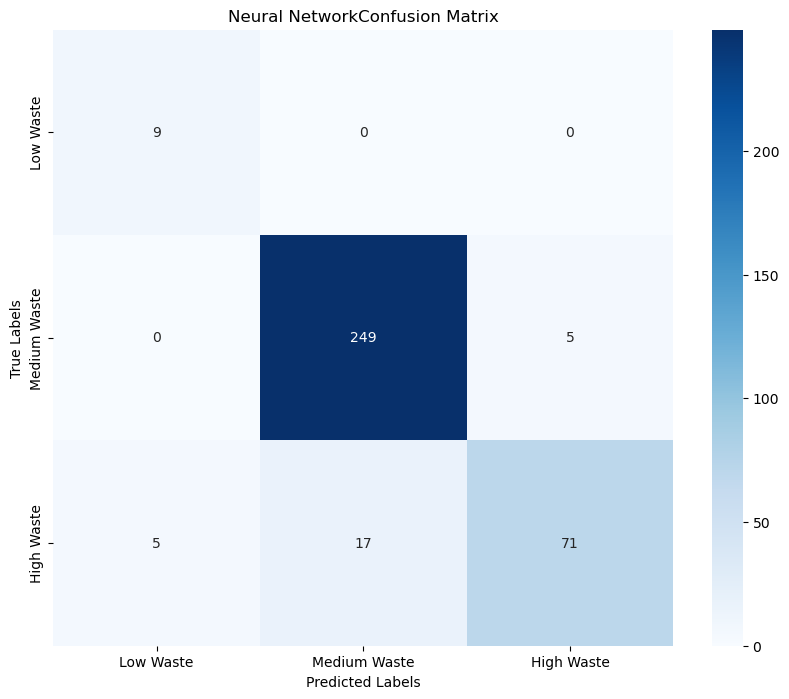

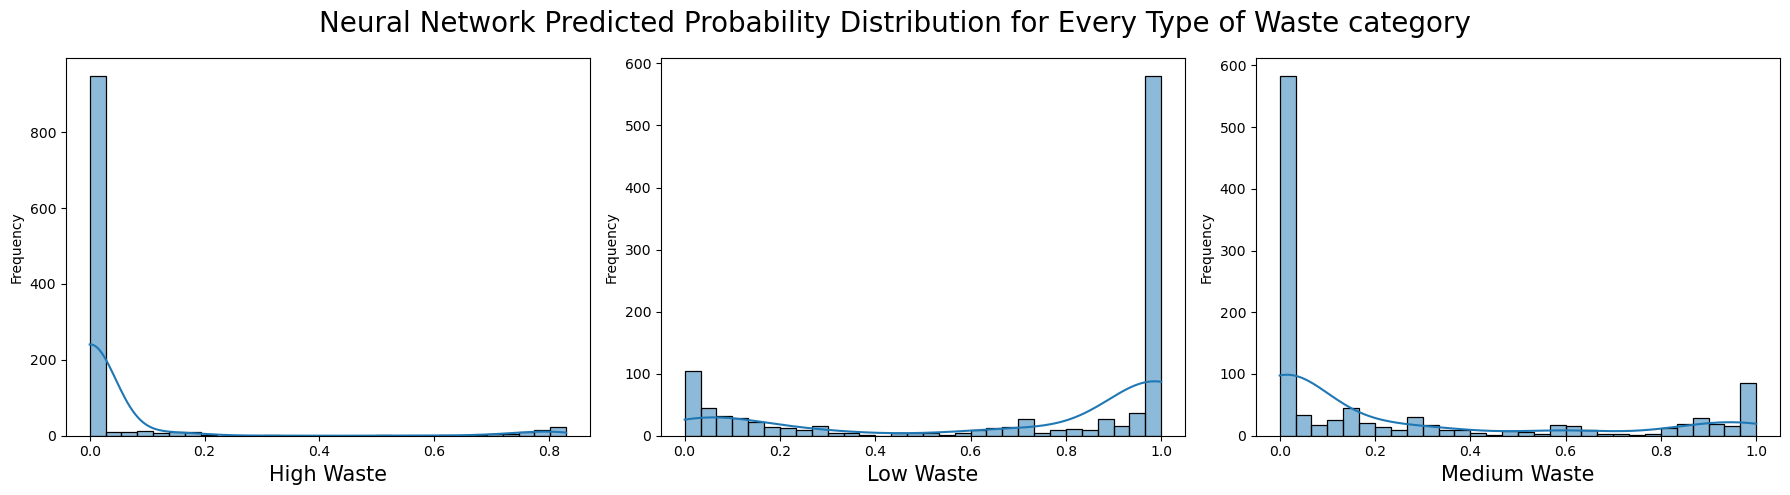

In [19]:
# Make predictions based on the final model for the validation/test set.
predict_validation = predict(X_validation.T, updated_parameters)

# Return y_validation_encoded to class indices for comparison
y_validation_indices = y_validation_encoded.argmax(axis=1)

# Produce the classification report
print("Neural Network Classification Report:")
print(classification_report(y_validation_indices, predict_validation, target_names=['Low Waste', 'Medium Waste', 'High Waste']))

# Compute the validation/test set's confusion matrix.
cm_nn = confusion_matrix(y_validation_indices, predict_validation)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Waste', 'Medium Waste', 'High Waste'], yticklabels=['Low Waste', 'Medium Waste', 'High Waste'])
plt.title('Neural NetworkConfusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Predict using the final model on the training set to obtain probabilities.
updated_predictions, probabilities = predict_with_proba(X_training.T, updated_parameters)

# Plot each class's expected probability distribution.
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
class_labels = encoder.categories_[0] 
for i, class_label in enumerate(class_labels):
    sns.histplot(probabilities[:, i], bins=30, kde=True, ax=ax[i])
    ax[i].set_xlabel(f'{class_label}', fontsize=15)
    ax[i].set_ylabel('Frequency')
    fig.suptitle('Neural Network Predicted Probability Distribution for Every Type of Waste category', fontsize=20)
plt.tight_layout()
plt.show()


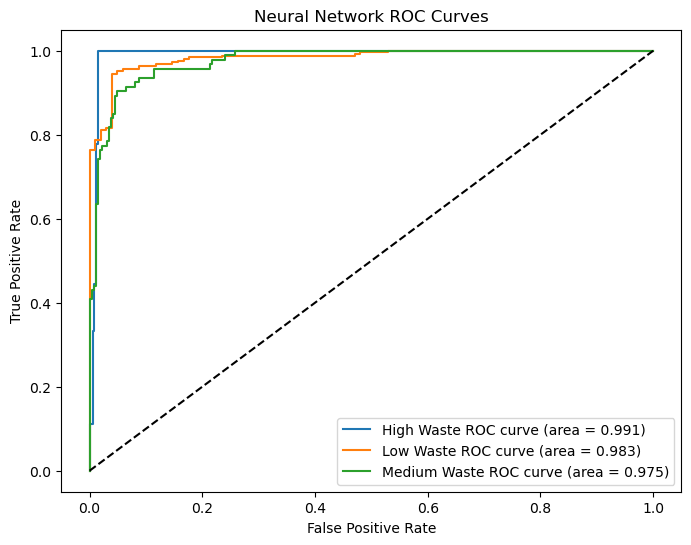

Neural Network Specificity of High Waste: 0.986
Neural Network Specificity of Low Waste: 0.833
Neural Network Specificity of Medium Waste: 0.981


In [20]:
# Made a dictionary that associates class labels with corresponding indices.
class_index = {label: index for index, label in enumerate(class_labels)}

# binarize y_test using the distinct classes from y_train.
y_binarize = label_binarize(y_test, classes=np.unique(y_train)) 

# Get the test set's softmax outputs.
_, softmax_outputs_test = predict_with_proba(X_test.T, updated_parameters)  # Ensure this uses the test set

# Calculate the ROC curve and ROC area for every test set class.
classes_list = y_binarize.shape[1]

# Set up dictionaries
false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

# Iterate over every class
for i in range(classes_list):
    # Compute the AUC and ROC curve for the current class.
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_binarize[:, i], softmax_outputs_test[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(classes_list):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'{class_labels[i]} ROC curve (area = {roc_auc[i]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curves')
plt.legend()
plt.show()

# specificity calculation
specificity_compute = {}
for class_label, index_class in class_index.items():
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])[:, index_class]
    specificity_compute[class_label] = specificity_computation(y_binarize, softmax_outputs_test, index_class)

# Print each specificity class value
for class_label in class_labels:
    print(f'Neural Network Specificity of {class_label}: {specificity_compute[class_label]:.3f}')


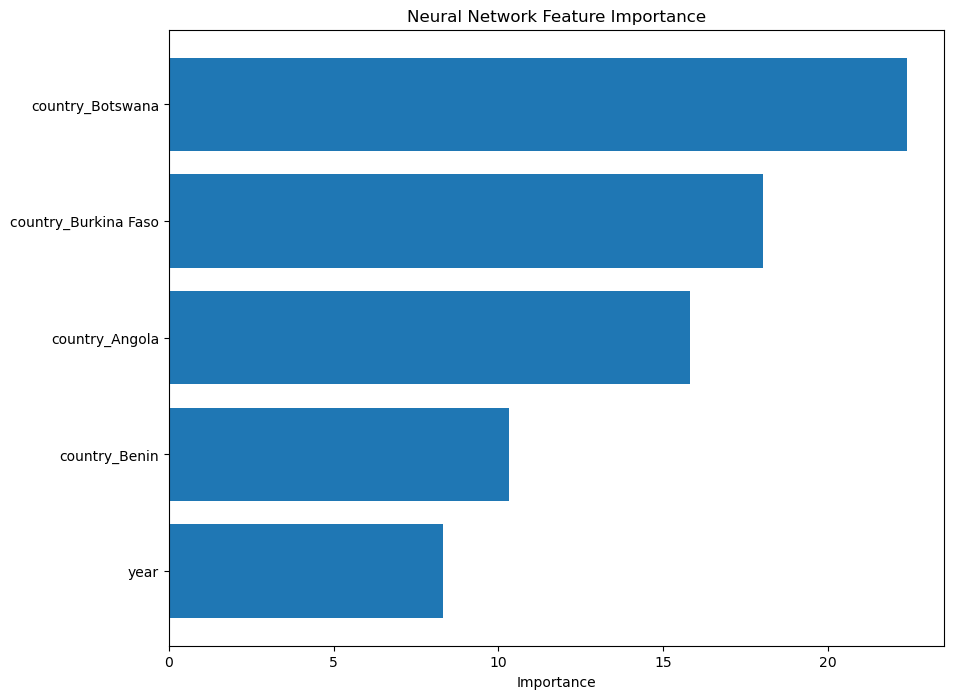

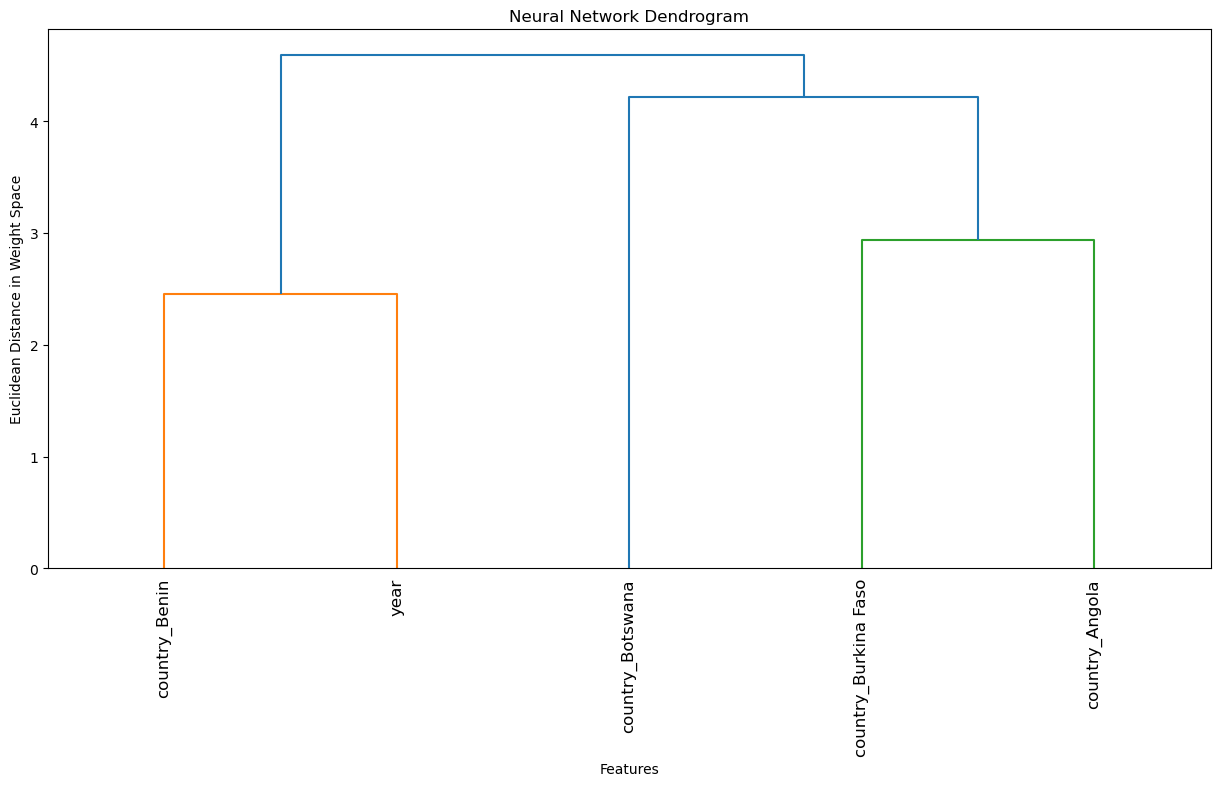

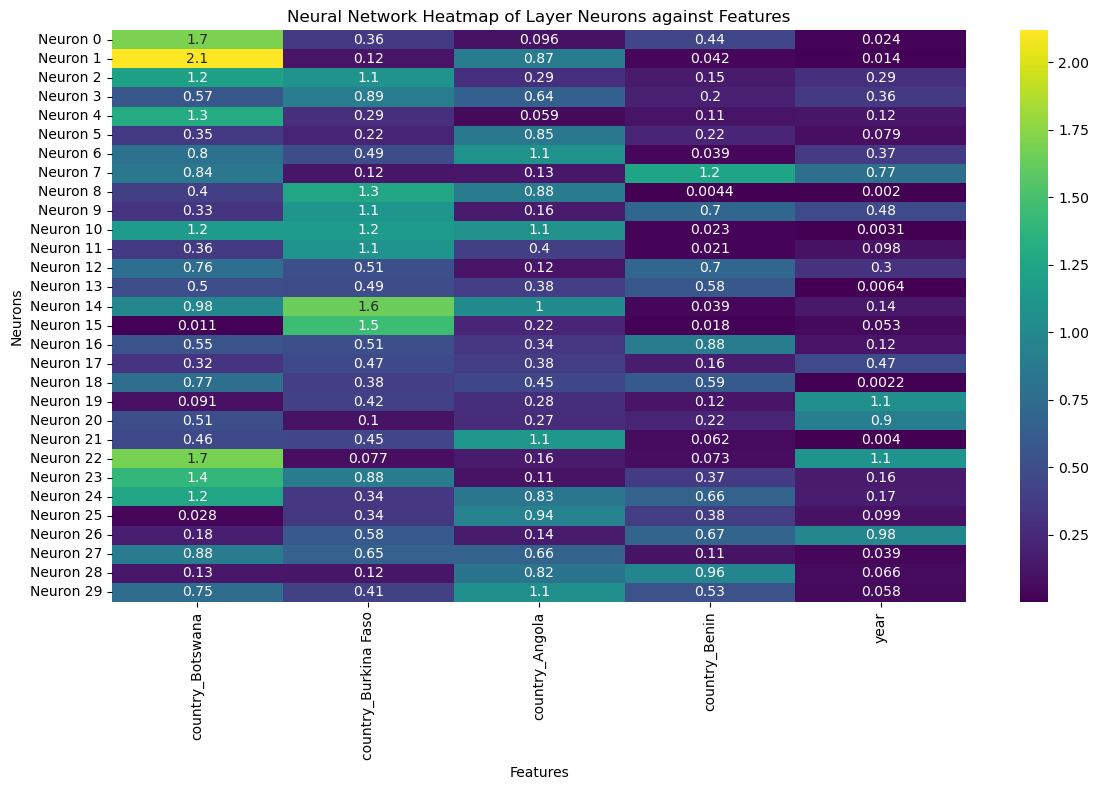

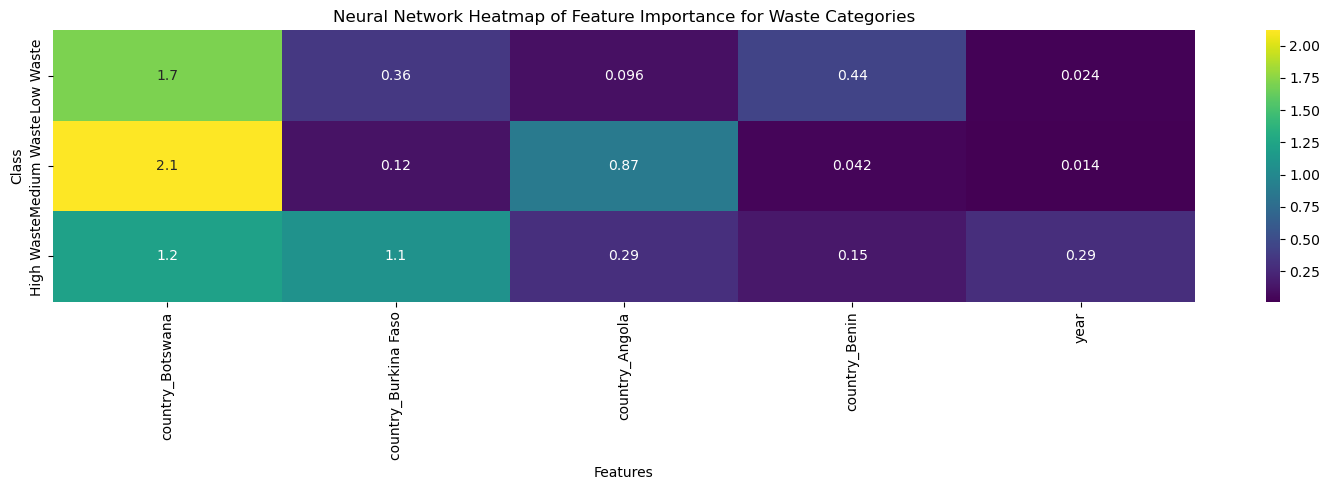

In [21]:
# Set up the ColumnTransformer for the neural network
transformer_nn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Fit the data and transform it
transformed_nn = transformer_nn.fit_transform(df)

# keep the numerical features the same
numerical_features = [name for name in transformer_nn.transformers_ if name[0] == 'num'][0][2]

# After one-hot encoding for each categorical features the features will be extracted
categorical_features = transformer_nn.named_transformers_['cat'].get_feature_names_out(categorical_features)

# get all the features into one
features = np.concatenate([numerical_features, categorical_features])


# Determine the feature importances based on the weights of the neural network layers
weights = np.abs(parameters['weight1'])
important_features = weights.sum(axis=0) 

# Clustering features based on importance
important_features_dict = dict(zip(features, important_features))
features_sorted = sorted(important_features_dict.items(), key=lambda item: item[1], reverse=True)
best_features = features_sorted[:20] 

# Plotting the top features
plt.figure(figsize=(10, 8))
plt.barh(range(len(best_features)), [val[1] for val in best_features], align='center')
plt.yticks(range(len(best_features)), [val[0] for val in best_features])
plt.xlabel('Importance')
plt.title('Neural Network Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Get new parameters
best_feature_names = [feature[0] for feature in best_features]
best_indices = [list(features).index(name) for name in best_feature_names]
best_weights = weights[:, best_indices]

# Top features dendrogram based on weights
Z_best_features = linkage(best_weights.T, 'ward')
plt.figure(figsize=(15, 7))
dendrogram(Z_best_features, labels=best_feature_names, leaf_rotation=90, leaf_font_size=12)
plt.title('Neural Network Dendrogram')
plt.xlabel('Features')
plt.ylabel('Euclidean Distance in Weight Space')
plt.show()

# Heatmap of the top features' first layer weights in the neural network
plt.figure(figsize=(12, 8))
sns.heatmap(best_weights, cmap='viridis', xticklabels=best_feature_names, yticklabels=[f'Neuron {i}' for i in range(best_weights.shape[0])], annot=True)
plt.title('Neural Network Heatmap of Layer Neurons against Features')
plt.xlabel('Features')
plt.ylabel('Neurons')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Extract weights in accordance with waste classifications
categories_weights = weights[:3, best_indices]

# Plotting the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(categories_weights, annot=True, cmap='viridis',
            xticklabels=best_feature_names, yticklabels=['Low Waste', 'Medium Waste', 'High Waste'])
plt.title('Neural Network Heatmap of Feature Importance for Waste Categories')
plt.xlabel('Features')
plt.ylabel('Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()